In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T

import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [ ]:
# Configuration
class Config:
    # Paths
    BASE_PATH = Path(r'd:/ai_project/heart_dataset')
    
    DATA_ENTRY_CSV = BASE_PATH / 'Data_Entry_2017.csv'
    BBOX_CSV = BASE_PATH / 'BBox_List_2017.csv'
    TRAIN_VAL_LIST = BASE_PATH / 'train_val_list.txt'
    TEST_LIST = BASE_PATH / 'test_list.txt'
    
    # Image folders - defined after BASE_PATH
    @staticmethod
    def get_image_folders():
        return [Config.BASE_PATH / f'images_{i:03d}' / 'images' for i in range(1, 13)]
    
    # Model configuration
    MODEL_NAME = 'densenet121'
    NUM_CLASSES = 14 # 14 diseases 
    IMAGE_SIZE = 224  # recommended for densenet121
    
    # Training hyperparameters
    BATCH_SIZE = 16  
    NUM_EPOCHS = 10  
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    VAL_SPLIT = 0.1  
    
    # Class names 
    CLASS_NAMES = [
        'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
        'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
        'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',
        'Pleural_Thickening', 'Hernia'
    ]
    
    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Output paths
    OUTPUT_DIR = Path(r'd:/ai_project/densenet_cam_results')
    CHECKPOINTS_DIR = OUTPUT_DIR / 'checkpoints'
    MODEL_SAVE_PATH = OUTPUT_DIR / 'best_densenet_model.pth'
    
config = Config()
config.IMAGE_FOLDERS = config.get_image_folders()
config.CHECKPOINTS_DIR.mkdir(exist_ok=True)

print(f"Device: {config.DEVICE}")
print(f"Number of classes: {config.NUM_CLASSES}")
print(f"Image size: {config.IMAGE_SIZE}")

print(f"Epochs: {config.NUM_EPOCHS}")
print(f"Classes: {config.CLASS_NAMES}")

Device: cuda
Number of classes: 14
Image size: 224
Epochs: 10
Classes: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']


In [ ]:
# Load metadata
df_metadata = pd.read_csv(config.DATA_ENTRY_CSV)
df_bbox = pd.read_csv(config.BBOX_CSV)

print(f"Total images in metadata: {len(df_metadata)}")
print(f"Total bounding boxes: {len(df_bbox)}")
print(f"\nMetadata columns: {df_metadata.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_metadata.head())

# Load given test and train files
with open(config.TRAIN_VAL_LIST, 'r') as f:
    train_val_images = set([line.strip() for line in f.readlines()])

with open(config.TEST_LIST, 'r') as f:
    test_images = set([line.strip() for line in f.readlines()])

print(f"\nTrain/Val images: {len(train_val_images)}")
print(f"Test images: {len(test_images)}")

# mapping image to patient id to prevent leakage
image_to_patient = dict(zip(df_metadata['Image Index'], df_metadata['Patient ID']))

print(f"\nSample finding labels distribution:")
print(df_metadata['Finding Labels'].value_counts().head(10))

Total images in metadata: 112120
Total bounding boxes: 984

Metadata columns: ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']

First few rows:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            P

In [ ]:
# splitting train and val using patent id 
train_val_patients = set([image_to_patient[img] for img in train_val_images if img in image_to_patient])
train_val_patients = sorted(list(train_val_patients))


np.random.seed(42)
np.random.shuffle(train_val_patients)

split_idx = int(len(train_val_patients) * (1 - config.VAL_SPLIT))
train_patients = set(train_val_patients[:split_idx])
val_patients = set(train_val_patients[split_idx:])

print(f"Total patients in train/val: {len(train_val_patients)}")
print(f"Train patients: {len(train_patients)}")
print(f"Validation patients: {len(val_patients)}")

# assigning images to train/val based on patient IDs
train_images = []
val_images = []

for img in train_val_images:
    if img in image_to_patient:
        patient_id = image_to_patient[img]
        if patient_id in train_patients:
            train_images.append(img)
        elif patient_id in val_patients:
            val_images.append(img)

train_images = set(train_images)
val_images = set(val_images)

print(f"\nFinal split:")
print(f"Train images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

# veryify no overlap to stop overfitting and leakage
test_patients = set([image_to_patient[img] for img in test_images if img in image_to_patient])
overlap_train_test = train_patients & test_patients
overlap_val_test = val_patients & test_patients
overlap_train_val = train_patients & val_patients

print(f"\nPatient overlap check (should all be 0):")
print(f"Train-Test overlap: {len(overlap_train_test)}")
print(f"Val-Test overlap: {len(overlap_val_test)}")
print(f"Train-Val overlap: {len(overlap_train_val)}")

Total patients in train/val: 28008
Train patients: 25207
Validation patients: 2801

Final split:
Train images: 77588
Validation images: 8936
Test images: 25596

Patient overlap check (should all be 0):
Train-Test overlap: 0
Val-Test overlap: 0
Train-Val overlap: 0

Final split:
Train images: 77588
Validation images: 8936
Test images: 25596

Patient overlap check (should all be 0):
Train-Test overlap: 0
Val-Test overlap: 0
Train-Val overlap: 0


In [ ]:
# Image Path
def find_image_path(image_name):
    # find the full path of an image
    for folder in config.IMAGE_FOLDERS:
        img_path = folder / image_name
        if img_path.exists():
            return img_path
    return None

# Process labels into multi-label format
def process_labels(finding_labels, class_names):
    #converting the finding labels into multi-hot encoded vector
    labels = np.zeros(len(class_names), dtype=np.float32)
    
    if finding_labels == 'No Finding':
        return labels  # All zeros for no finding
    
    findings = finding_labels.split('|')
    for finding in findings:
        if finding in class_names:
            idx = class_names.index(finding)
            labels[idx] = 1.0
    
    return labels

# Test the functions
sample_img = list(train_images)[0]
sample_path = find_image_path(sample_img)
print(f"Sample image: {sample_img}")
print(f"Found at: {sample_path}")

sample_labels = df_metadata[df_metadata['Image Index'] == sample_img]['Finding Labels'].values[0]
sample_encoded = process_labels(sample_labels, config.CLASS_NAMES)
print(f"\nSample labels: {sample_labels}")
print(f"Encoded: {sample_encoded}")
print(f"Active classes: {[config.CLASS_NAMES[i] for i, val in enumerate(sample_encoded) if val == 1]}")

Sample image: 00009764_002.png
Found at: d:\ai_project\heart_dataset\images_005\images\00009764_002.png

Sample labels: Mass
Encoded: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Active classes: ['Mass']


In [ ]:
class ChestXrayDataset(Dataset):
    
    def __init__(self, image_list, metadata_df, class_names, transform=None):
        self.image_list = list(image_list)
        self.metadata_df = metadata_df
        self.class_names = class_names
        self.transform = transform
        
        
        self.metadata_dict = {}
        for _, row in metadata_df.iterrows():
            self.metadata_dict[row['Image Index']] = row
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        
        # Find image path
        img_path = find_image_path(img_name)
        if img_path is None:
            raise FileNotFoundError(f"Image not found: {img_name}")
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Get labels
        metadata = self.metadata_dict.get(img_name)
        if metadata is None:
            raise ValueError(f"No metadata for image: {img_name}")
        
        finding_labels = metadata['Finding Labels']
        labels = process_labels(finding_labels, self.class_names)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return {
            'image': image,
            'labels': torch.tensor(labels, dtype=torch.float32),
            'image_name': img_name
        }

# Define transforms
train_transform = T.Compose([
    T.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = T.Compose([
    T.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ChestXrayDataset(train_images, df_metadata, config.CLASS_NAMES, transform=train_transform)
val_dataset = ChestXrayDataset(val_images, df_metadata, config.CLASS_NAMES, transform=val_test_transform)
test_dataset = ChestXrayDataset(test_images, df_metadata, config.CLASS_NAMES, transform=val_test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train dataset: {len(train_dataset)} images")
print(f"Validation dataset: {len(val_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")
print(f"\nTrain batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train dataset: 77588 images
Validation dataset: 8936 images
Test dataset: 25596 images

Train batches: 4850
Validation batches: 559
Test batches: 1600


Batch image shape: torch.Size([16, 3, 224, 224])
Batch labels shape: torch.Size([16, 14])


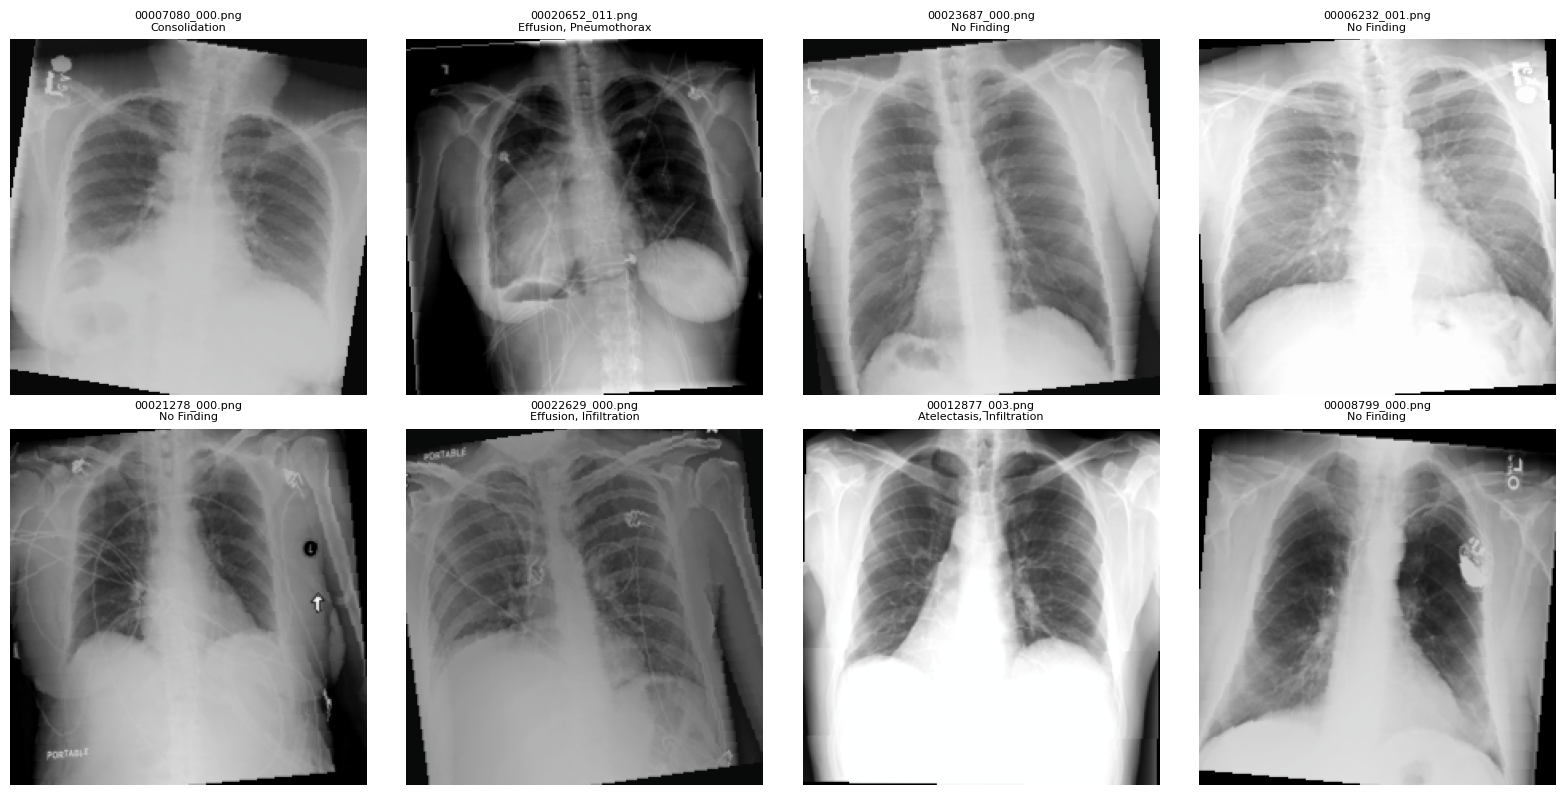

Computing class distribution:   0%|          | 0/4850 [00:00<?, ?it/s]

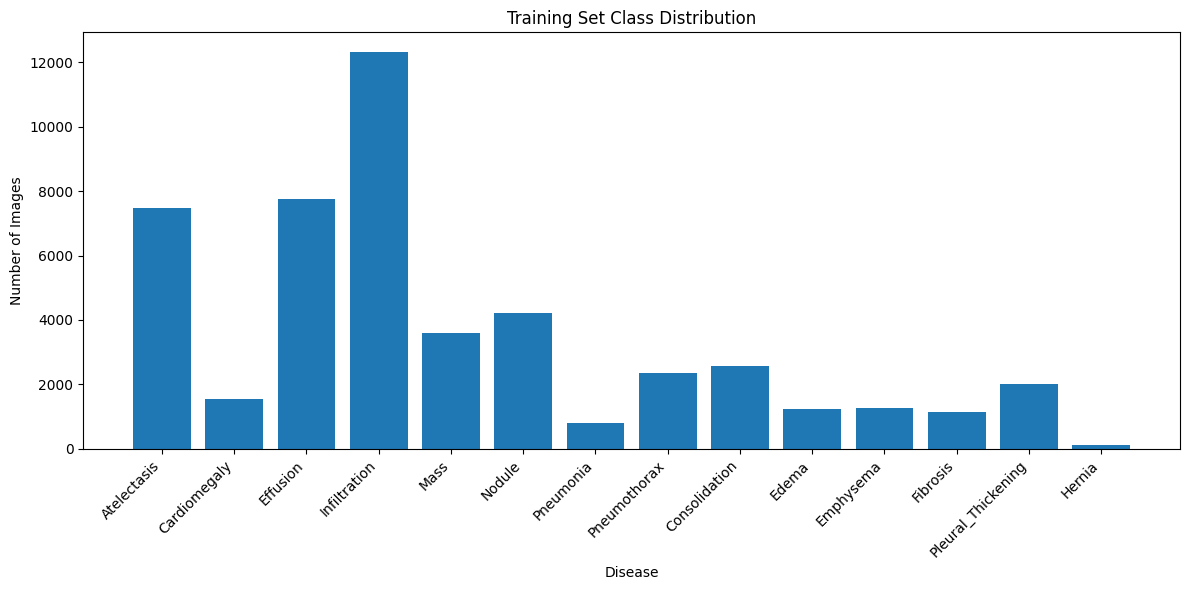


Class distribution:
Atelectasis: 7467 (9.62%)
Cardiomegaly: 1554 (2.00%)
Effusion: 7749 (9.99%)
Infiltration: 12312 (15.87%)
Mass: 3611 (4.65%)
Nodule: 4218 (5.44%)
Pneumonia: 789 (1.02%)
Pneumothorax: 2369 (3.05%)
Consolidation: 2564 (3.30%)
Edema: 1236 (1.59%)
Emphysema: 1274 (1.64%)
Fibrosis: 1139 (1.47%)
Pleural_Thickening: 2025 (2.61%)
Hernia: 121 (0.16%)


In [ ]:
# Visualize a batch
batch = next(iter(train_loader))
print(f"Batch image shape: {batch['image'].shape}")
print(f"Batch labels shape: {batch['labels'].shape}")


fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i in range(8):
    img = batch['image'][i].permute(1, 2, 0).numpy()
    # Denormalize
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    labels = batch['labels'][i].numpy()
    active_classes = [config.CLASS_NAMES[j] for j, val in enumerate(labels) if val == 1]
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"{batch['image_name'][i]}\n{', '.join(active_classes) if active_classes else 'No Finding'}", 
                      fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# checkign class distribution
all_labels = []
for batch in tqdm(train_loader, desc="class distribution"):
    all_labels.append(batch['labels'].numpy())

all_labels = np.vstack(all_labels)
class_counts = all_labels.sum(axis=0)

plt.figure(figsize=(12, 6))
plt.bar(range(len(config.CLASS_NAMES)), class_counts)
plt.xticks(range(len(config.CLASS_NAMES)), config.CLASS_NAMES, rotation=45, ha='right')
plt.xlabel('Disease')
plt.ylabel('Number of Images')
plt.title('Training Set Class Distribution')
plt.tight_layout()
plt.show()

print("\nClass distribution:")
for i, name in enumerate(config.CLASS_NAMES):
    print(f"{name}: {int(class_counts[i])} ({class_counts[i]/len(train_dataset)*100:.2f}%)")

In [ ]:
import torchvision.models as models

class DenseNetCAM(nn.Module):
    # DenseNet-121 with Global Average Pooling for Class Activation Mapping
    
    def __init__(self, num_classes=14, pretrained=True):
        super(DenseNetCAM, self).__init__()
        
        # pretrained model
        densenet = models.densenet121(pretrained=pretrained)
        
        # Extract features 
        self.features = densenet.features
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Get number of features from last layer
        num_features = densenet.classifier.in_features
        
        # Classification layer 
        self.classifier = nn.Linear(num_features, num_classes)
        
        # Store for CAM generation
        self.feature_maps = None
        self.gradients = None
    
    def forward(self, x):
        # Extract features
        features = self.features(x)
        
        # feature map for CAM
        self.feature_maps = features
        
        # Register hook for gradients if in training mode
        if features.requires_grad:
            features.register_hook(self.save_gradient)
        
        # Global Average Pooling
        pooled = self.gap(features)
        pooled = pooled.view(pooled.size(0), -1)
        
        # Classification
        output = self.classifier(pooled)
        
        return output
    
    def save_gradient(self, grad):
    
        self.gradients = grad
    
    def get_cam(self, class_idx):
      
        # Get weights for the specific class
        weights = self.classifier.weight[class_idx].detach().cpu().numpy()
        
        # Get feature maps
        feature_maps = self.feature_maps.detach().cpu().numpy()
        
        # Generate CAM by weighted combination of feature maps
        # feature_maps shape: (batch, channels, H, W)
        # weights shape: (channels,)
        cam = np.zeros((feature_maps.shape[2], feature_maps.shape[3]), dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * feature_maps[0, i, :, :]
        
        # Apply ReLU to keep only positive contributions
        cam = np.maximum(cam, 0)
        
        # Normalize to [0, 1]
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam

# Create model
model = DenseNetCAM(num_classes=config.NUM_CLASSES, pretrained=True)
model = model.to(config.DEVICE)

print(f"Model created: DenseNet-121 with CAM support")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model created: DenseNet-121 with CAM support
Number of parameters: 6,968,206
Number of trainable parameters: 6,968,206


## 5. Loss Function and Optimizer

In [9]:
# Multi-label classification uses Binary Cross Entropy with Logits
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

print(f"Loss function: BCEWithLogitsLoss (for multi-label classification)")
print(f"Optimizer: Adam (lr={config.LEARNING_RATE}, weight_decay={config.WEIGHT_DECAY})")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")

Loss function: BCEWithLogitsLoss (for multi-label classification)
Optimizer: Adam (lr=0.0001, weight_decay=1e-05)
Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)


## 6. Training and Evaluation Functions

In [10]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    
    pbar = tqdm(dataloader, desc="Training")
    for batch in pbar:
        images = batch['image'].to(device)
        labels = batch['labels'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        
        # Store predictions and labels
        predictions = torch.sigmoid(outputs).detach().cpu().numpy()
        all_predictions.append(predictions)
        all_labels.append(labels.cpu().numpy())
        
        pbar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Compute metrics
    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    
    # AUC for each class
    try:
        auc_scores = []
        for i in range(all_labels.shape[1]):
            if len(np.unique(all_labels[:, i])) > 1:  # Only compute if both classes present
                auc = roc_auc_score(all_labels[:, i], all_predictions[:, i])
                auc_scores.append(auc)
        mean_auc = np.mean(auc_scores) if auc_scores else 0.0
    except:
        mean_auc = 0.0
    
    return epoch_loss, mean_auc

def evaluate(model, dataloader, criterion, device):
    """Evaluate the model"""
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Evaluating")
        for batch in pbar:
            images = batch['image'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            
            # Store predictions and labels
            predictions = torch.sigmoid(outputs).cpu().numpy()
            all_predictions.append(predictions)
            all_labels.append(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Compute metrics
    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    
    # AUC for each class
    auc_scores = []
    for i in range(all_labels.shape[1]):
        if len(np.unique(all_labels[:, i])) > 1:
            auc = roc_auc_score(all_labels[:, i], all_predictions[:, i])
            auc_scores.append(auc)
        else:
            auc_scores.append(0.0)
    
    mean_auc = np.mean(auc_scores)
    
    # Per-class AUC
    class_auc_dict = {config.CLASS_NAMES[i]: auc_scores[i] for i in range(len(config.CLASS_NAMES))}
    
    return epoch_loss, mean_auc, class_auc_dict, all_predictions, all_labels

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


In [11]:
# Training history
history = {
    'train_loss': [],
    'train_auc': [],
    'val_loss': [],
    'val_auc': []
}

best_val_auc = 0.0
best_epoch = 0

print(f"Starting training for {config.NUM_EPOCHS} epochs...")
print(f"Device: {config.DEVICE}")
print("="*80)

for epoch in range(config.NUM_EPOCHS):
    start_time = time.time()
    
    print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
    print("-" * 80)
    
    # Train
    train_loss, train_auc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
    
    # Validate
    val_loss, val_auc, val_class_auc, _, _ = evaluate(model, val_loader, criterion, config.DEVICE)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    
    epoch_time = time.time() - start_time
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}")
    print(f"  Time: {epoch_time:.2f}s")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save checkpoint for every epoch
    checkpoint_path = config.CHECKPOINTS_DIR / f'densenet_epoch_{epoch+1:02d}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'train_auc': train_auc,
        'val_loss': val_loss,
        'val_auc': val_auc,
        'class_auc': val_class_auc,
        'history': history.copy()
    }, checkpoint_path)
    print(f"  💾 Checkpoint saved: {checkpoint_path.name}")
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': val_auc,
            'val_loss': val_loss,
            'class_auc': val_class_auc
        }, config.MODEL_SAVE_PATH)
        print(f"  ✓ Best model saved! (AUC: {val_auc:.4f})")
    
    print("="*80)

print(f"\nTraining completed!")
print(f"Best validation AUC: {best_val_auc:.4f} (Epoch {best_epoch})")
print(f"All epoch checkpoints saved in: {config.CHECKPOINTS_DIR}")

Starting training for 10 epochs...
Device: cuda

Epoch 1/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/559 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 0.1506 | Train AUC: 0.7363
  Val Loss: 0.1382 | Val AUC: 0.7862
  Time: 3079.02s
  LR: 0.000100
  💾 Checkpoint saved: densenet_epoch_01.pth
  💾 Checkpoint saved: densenet_epoch_01.pth
  ✓ Best model saved! (AUC: 0.7862)

Epoch 2/10
--------------------------------------------------------------------------------
  ✓ Best model saved! (AUC: 0.7862)

Epoch 2/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/559 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 0.1369 | Train AUC: 0.8002
  Val Loss: 0.1347 | Val AUC: 0.7998
  Time: 3175.20s
  LR: 0.000100
  💾 Checkpoint saved: densenet_epoch_02.pth
  💾 Checkpoint saved: densenet_epoch_02.pth
  ✓ Best model saved! (AUC: 0.7998)

Epoch 3/10
--------------------------------------------------------------------------------
  ✓ Best model saved! (AUC: 0.7998)

Epoch 3/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/559 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 0.1342 | Train AUC: 0.8162
  Val Loss: 0.1335 | Val AUC: 0.8117
  Time: 3070.08s
  LR: 0.000100
  💾 Checkpoint saved: densenet_epoch_03.pth
  💾 Checkpoint saved: densenet_epoch_03.pth
  ✓ Best model saved! (AUC: 0.8117)

Epoch 4/10
--------------------------------------------------------------------------------
  ✓ Best model saved! (AUC: 0.8117)

Epoch 4/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/559 [00:00<?, ?it/s]


Epoch 4 Summary:
  Train Loss: 0.1325 | Train AUC: 0.8243
  Val Loss: 0.1331 | Val AUC: 0.8238
  Time: 3053.69s
  LR: 0.000100
  💾 Checkpoint saved: densenet_epoch_04.pth
  💾 Checkpoint saved: densenet_epoch_04.pth
  ✓ Best model saved! (AUC: 0.8238)

Epoch 5/10
--------------------------------------------------------------------------------
  ✓ Best model saved! (AUC: 0.8238)

Epoch 5/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/559 [00:00<?, ?it/s]


Epoch 5 Summary:
  Train Loss: 0.1307 | Train AUC: 0.8334
  Val Loss: 0.1317 | Val AUC: 0.8217
  Time: 3069.61s
  LR: 0.000100
  💾 Checkpoint saved: densenet_epoch_05.pth

Epoch 6/10
--------------------------------------------------------------------------------
  💾 Checkpoint saved: densenet_epoch_05.pth

Epoch 6/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/559 [00:00<?, ?it/s]


Epoch 6 Summary:
  Train Loss: 0.1294 | Train AUC: 0.8396
  Val Loss: 0.1311 | Val AUC: 0.8238
  Time: 3085.52s
  LR: 0.000100
  💾 Checkpoint saved: densenet_epoch_06.pth
  💾 Checkpoint saved: densenet_epoch_06.pth
  ✓ Best model saved! (AUC: 0.8238)

Epoch 7/10
--------------------------------------------------------------------------------
  ✓ Best model saved! (AUC: 0.8238)

Epoch 7/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/559 [00:00<?, ?it/s]


Epoch 7 Summary:
  Train Loss: 0.1281 | Train AUC: 0.8454
  Val Loss: 0.1305 | Val AUC: 0.8279
  Time: 3183.58s
  LR: 0.000100
  💾 Checkpoint saved: densenet_epoch_07.pth
  💾 Checkpoint saved: densenet_epoch_07.pth
  ✓ Best model saved! (AUC: 0.8279)

Epoch 8/10
--------------------------------------------------------------------------------
  ✓ Best model saved! (AUC: 0.8279)

Epoch 8/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/559 [00:00<?, ?it/s]


Epoch 8 Summary:
  Train Loss: 0.1268 | Train AUC: 0.8511
  Val Loss: 0.1309 | Val AUC: 0.8299
  Time: 3089.31s
  LR: 0.000100
  💾 Checkpoint saved: densenet_epoch_08.pth
  💾 Checkpoint saved: densenet_epoch_08.pth
  ✓ Best model saved! (AUC: 0.8299)

Epoch 9/10
--------------------------------------------------------------------------------
  ✓ Best model saved! (AUC: 0.8299)

Epoch 9/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/559 [00:00<?, ?it/s]


Epoch 9 Summary:
  Train Loss: 0.1258 | Train AUC: 0.8556
  Val Loss: 0.1314 | Val AUC: 0.8253
  Time: 3018.00s
  LR: 0.000100
  💾 Checkpoint saved: densenet_epoch_09.pth

Epoch 10/10
--------------------------------------------------------------------------------
  💾 Checkpoint saved: densenet_epoch_09.pth

Epoch 10/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/559 [00:00<?, ?it/s]


Epoch 10 Summary:
  Train Loss: 0.1245 | Train AUC: 0.8593
  Val Loss: 0.1341 | Val AUC: 0.8283
  Time: 3030.76s
  LR: 0.000050
  💾 Checkpoint saved: densenet_epoch_10.pth

Training completed!
Best validation AUC: 0.8299 (Epoch 8)
All epoch checkpoints saved in: d:\ai_project\densenet_cam_results\checkpoints
  💾 Checkpoint saved: densenet_epoch_10.pth

Training completed!
Best validation AUC: 0.8299 (Epoch 8)
All epoch checkpoints saved in: d:\ai_project\densenet_cam_results\checkpoints


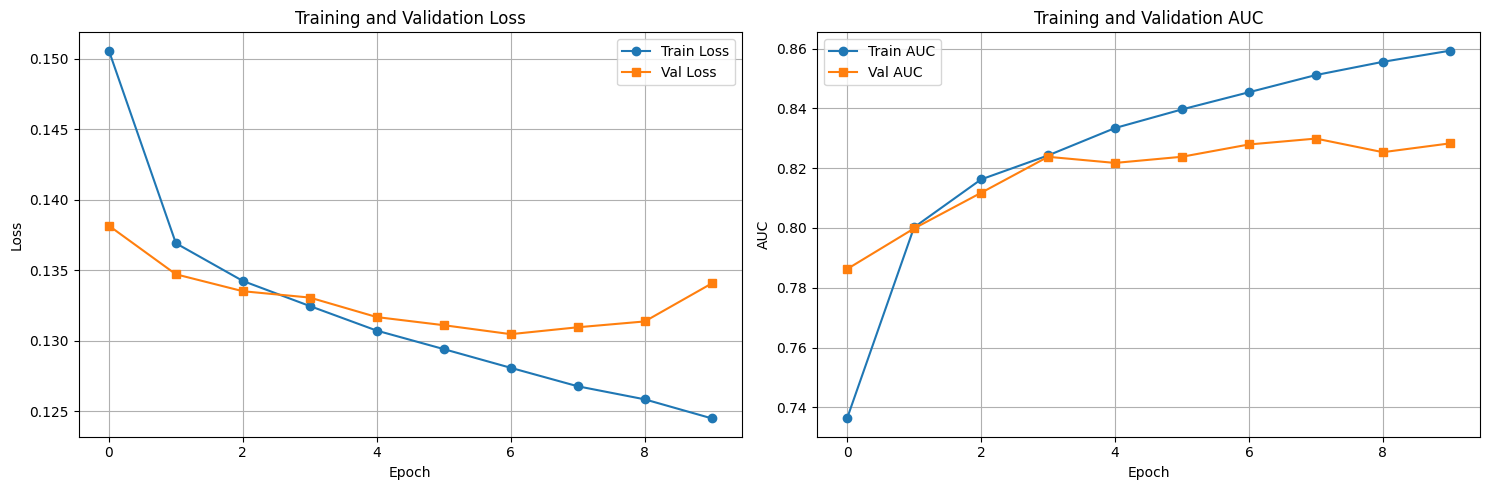

In [12]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# AUC
axes[1].plot(history['train_auc'], label='Train AUC', marker='o')
axes[1].plot(history['val_auc'], label='Val AUC', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('Training and Validation AUC')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Test Set Evaluation

In [ ]:

USE_BEST_MODEL = False
LOAD_EPOCH = 8  

if USE_BEST_MODEL:
    print("Loading best model...")
    checkpoint_path = config.MODEL_SAVE_PATH
else:
    print(f"Loading model from epoch {LOAD_EPOCH}...")
    checkpoint_path = config.CHECKPOINTS_DIR / f'densenet_epoch_{LOAD_EPOCH:02d}.pth'
    if not checkpoint_path.exists():
        print(f"Checkpoint not found: {checkpoint_path}")
        print("Available checkpoints:")
        for ckpt in sorted(config.CHECKPOINTS_DIR.glob('*.pth')):
            print(f"  - {ckpt.name}")
        raise FileNotFoundError(f"Checkpoint for epoch {LOAD_EPOCH} not found")

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Model from epoch {checkpoint['epoch']+1} loaded.")
print(f"Validation AUC: {checkpoint['val_auc']:.4f}")

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_auc, test_class_auc, test_predictions, test_labels = evaluate(
    model, test_loader, criterion, config.DEVICE
)

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Mean AUC: {test_auc:.4f}")
print("\n  Per-class AUC:")
for class_name, auc in test_class_auc.items():
    print(f"    {class_name:20s}: {auc:.4f}")

# Save results
results = {
    'test_loss': float(test_loss),
    'test_mean_auc': float(test_auc),
    'test_class_auc': {k: float(v) for k, v in test_class_auc.items()},
    'best_epoch': int(checkpoint['epoch'] + 1),
    'validation_auc': float(checkpoint['val_auc'])
}

import json
with open(config.OUTPUT_DIR / 'test_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print(f"\nResults saved to {config.OUTPUT_DIR / 'test_results.json'}")

Loading model from epoch 8...
Model from epoch 8 loaded.
Validation AUC: 0.8299

Evaluating on test set...
Model from epoch 8 loaded.
Validation AUC: 0.8299

Evaluating on test set...


Evaluating:   0%|          | 0/1600 [00:00<?, ?it/s]


Test Results:
  Loss: 0.2065
  Mean AUC: 0.8046

  Per-class AUC:
    Atelectasis         : 0.7720
    Cardiomegaly        : 0.8755
    Effusion            : 0.8231
    Infiltration        : 0.7058
    Mass                : 0.8156
    Nodule              : 0.7510
    Pneumonia           : 0.7124
    Pneumothorax        : 0.8577
    Consolidation       : 0.7465
    Edema               : 0.8308
    Emphysema           : 0.9096
    Fibrosis            : 0.8081
    Pleural_Thickening  : 0.7676
    Hernia              : 0.8889

Results saved to d:\ai_project\densenet_cam_results\test_results.json


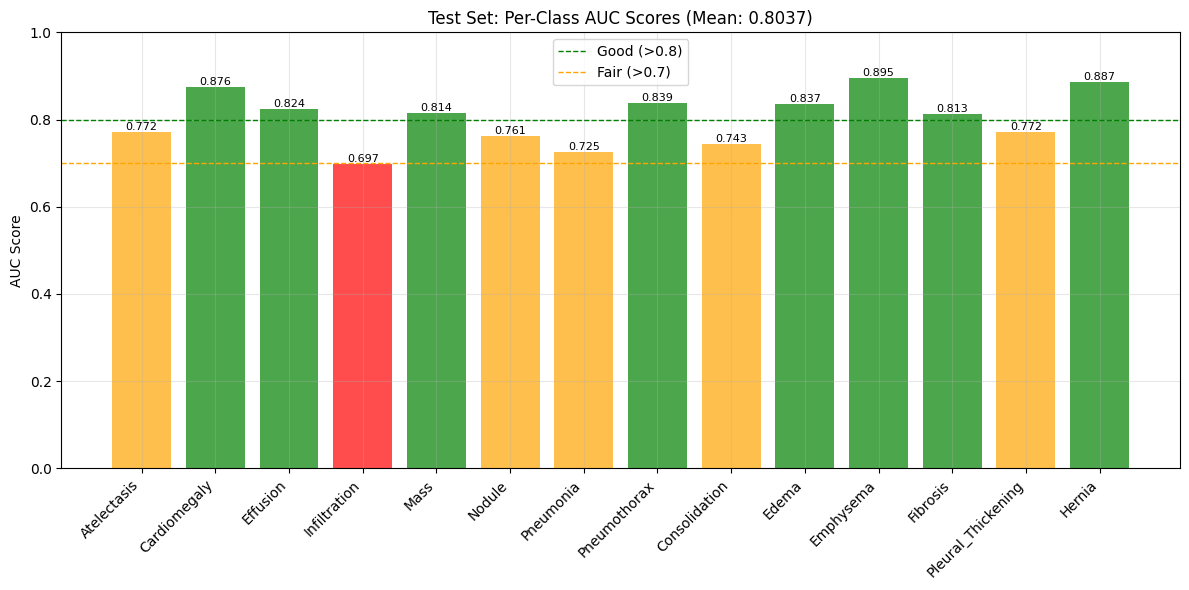

In [26]:
# Plot per-class AUC comparison
fig, ax = plt.subplots(figsize=(12, 6))

classes = list(test_class_auc.keys())
aucs = list(test_class_auc.values())

colors = ['green' if auc > 0.8 else 'orange' if auc > 0.7 else 'red' for auc in aucs]

bars = ax.bar(range(len(classes)), aucs, color=colors, alpha=0.7)
ax.axhline(y=0.8, color='green', linestyle='--', label='Good (>0.8)', linewidth=1)
ax.axhline(y=0.7, color='orange', linestyle='--', label='Fair (>0.7)', linewidth=1)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_ylabel('AUC Score')
ax.set_title(f'Test Set: Per-Class AUC Scores (Mean: {test_auc:.4f})')
ax.set_ylim(0, 1.0)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, auc) in enumerate(zip(bars, aucs)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{auc:.3f}',
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'test_class_auc.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
import cv2

def generate_cam_visualization(model, image_tensor, original_image, class_idx, class_name, alpha=0.5):
    model.eval()
    
    # Forward pass
    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.sigmoid(output)[0, class_idx].item()
    
    # Generate CAM
    cam = model.get_cam(class_idx)
    
    # Resize CAM to original image size
    original_size = original_image.size  # (W, H)
    cam_resized = cv2.resize(cam, original_size)
    
    # Normalize to 0-255
    cam_normalized = (cam_resized * 255).astype(np.uint8)
    
    # Apply colormap
    heatmap = cv2.applyColorMap(cam_normalized, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Convert original image to numpy array
    original_np = np.array(original_image)
    if len(original_np.shape) == 2:  # Grayscale
        original_np = cv2.cvtColor(original_np, cv2.COLOR_GRAY2RGB)
    
    # Overlay
    overlayed = cv2.addWeighted(original_np, 1-alpha, heatmap, alpha, 0)
    
    return overlayed, cam_resized, prediction

print("CAM visualization function defined.")

CAM visualization function defined.


In [10]:
# Visualize CAMs for test samples with bounding boxes (if available)
def visualize_cam_with_bbox(image_name, class_name, save=True):
    """Visualize CAM for a specific image and class, with ground truth bbox if available"""
    
    # Find image
    img_path = find_image_path(image_name)
    if img_path is None:
        print(f"Image {image_name} not found!")
        return
    
    # Load original image
    original_image = Image.open(img_path).convert('RGB')
    
    # Preprocess for model
    image_tensor = val_test_transform(original_image).unsqueeze(0).to(config.DEVICE)
    
    # Get class index
    if class_name not in config.CLASS_NAMES:
        print(f"Class {class_name} not found!")
        return
    class_idx = config.CLASS_NAMES.index(class_name)
    
    # Generate CAM
    overlayed, cam, prediction = generate_cam_visualization(
        model, image_tensor, original_image, class_idx, class_name
    )
    
    # Check if there's a bounding box for this image and class
    bbox_rows = df_bbox[(df_bbox['Image Index'] == image_name) & 
                        (df_bbox['Finding Label'] == class_name)]
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original image
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title(f'Original Image\n{image_name}')
    axes[0].axis('off')
    
    # Add bounding box if available
    if len(bbox_rows) > 0:
        for _, bbox_row in bbox_rows.iterrows():
            x, y, w, h = bbox_row['Bbox [x'], bbox_row['y'], bbox_row['w'], bbox_row['h]']
            rect = patches.Rectangle((x, y), w, h, linewidth=2, 
                                     edgecolor='red', facecolor='none', label='Ground Truth')
            axes[0].add_patch(rect)
        axes[0].legend()
    
    # CAM heatmap
    axes[1].imshow(cam, cmap='jet')
    axes[1].set_title(f'Class Activation Map\n{class_name} (Pred: {prediction:.3f})')
    axes[1].axis('off')
    
    # Overlayed
    axes[2].imshow(overlayed)
    axes[2].set_title(f'Overlayed Visualization\n{class_name}')
    axes[2].axis('off')
    
    # Add bbox to overlay if available
    if len(bbox_rows) > 0:
        for _, bbox_row in bbox_rows.iterrows():
            x, y, w, h = bbox_row['Bbox [x'], bbox_row['y'], bbox_row['w'], bbox_row['h]']
            rect = patches.Rectangle((x, y), w, h, linewidth=2, 
                                     edgecolor='red', facecolor='none', label='Ground Truth')
            axes[2].add_patch(rect)
        axes[2].legend()
    
    plt.tight_layout()
    
    if save:
        save_path = config.OUTPUT_DIR / f'cam_{image_name[:-4]}_{class_name}.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    plt.show()
    
    return overlayed, cam, prediction

print("CAM visualization with bbox function defined.")

CAM visualization with bbox function defined.


In [15]:
# Find test images with bounding boxes for visualization
test_images_with_bbox = df_bbox[df_bbox['Image Index'].isin(test_images)]
print(f"Test images with bounding boxes: {len(test_images_with_bbox)}")
print("\nSample images with bboxes:")
print(test_images_with_bbox.head(10))

# Count by class
print("\nBounding boxes per class in test set:")
print(test_images_with_bbox['Finding Label'].value_counts())

Test images with bounding boxes: 984

Sample images with bboxes:
        Image Index Finding Label     Bbox [x           y           w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   
5  00003148_004.png   Atelectasis  596.067797  505.780787   56.406780   
6  00012515_002.png   Atelectasis  289.084746  638.137861   83.525424   
7  00022098_006.png   Atelectasis  494.101695  577.392098  271.186441   
8  00014198_000.png   Atelectasis  676.338983  512.307352   98.711864   
9  00021007_000.png   Atelectasis  344.406780  468.917522  105.220339   

           h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  
0   79.186441         NaN         NaN         NaN  
1  313.491525         NaN  


Visualizing: Atelectasis - 00013118_008.png
Saved to d:\ai_project\densenet_cam_results\cam_00013118_008_Atelectasis.png
Saved to d:\ai_project\densenet_cam_results\cam_00013118_008_Atelectasis.png


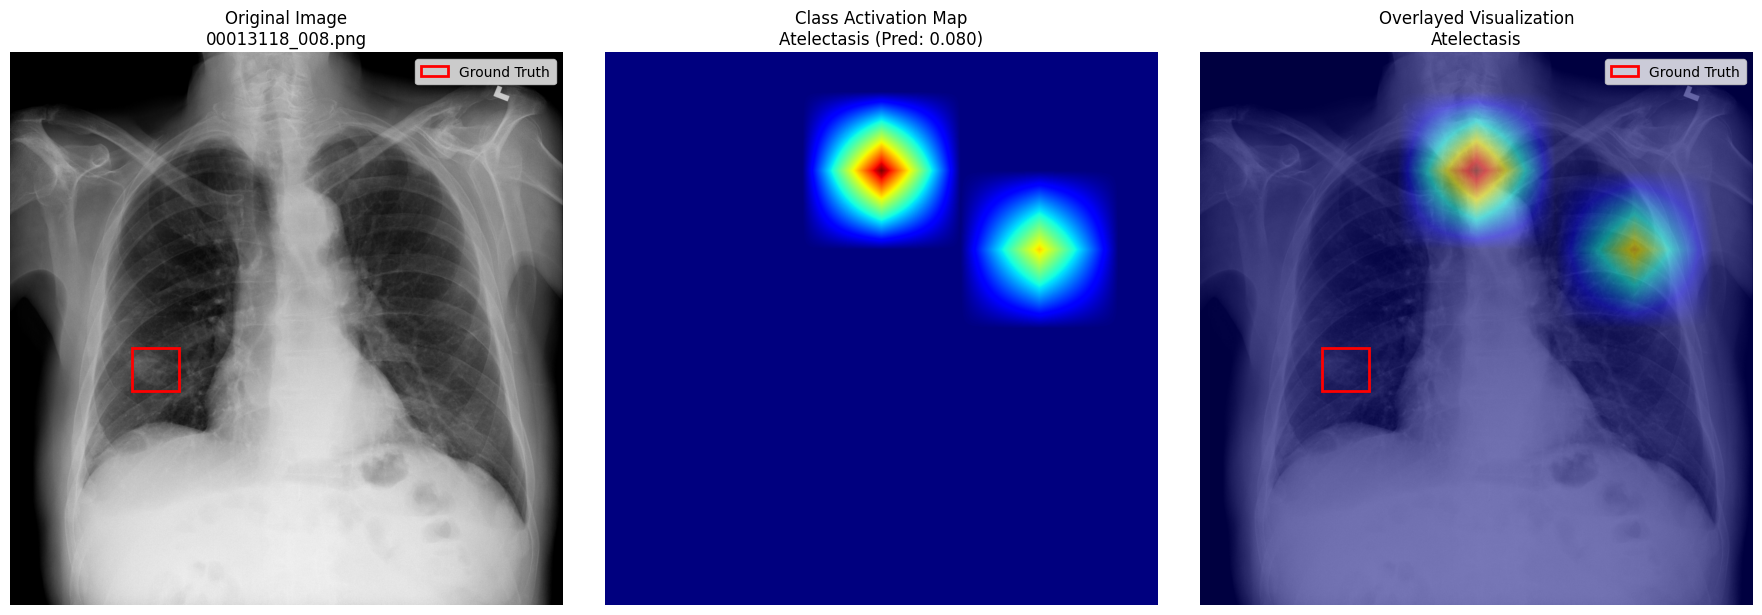


Visualizing: Cardiomegaly - 00005066_030.png
Saved to d:\ai_project\densenet_cam_results\cam_00005066_030_Cardiomegaly.png
Saved to d:\ai_project\densenet_cam_results\cam_00005066_030_Cardiomegaly.png


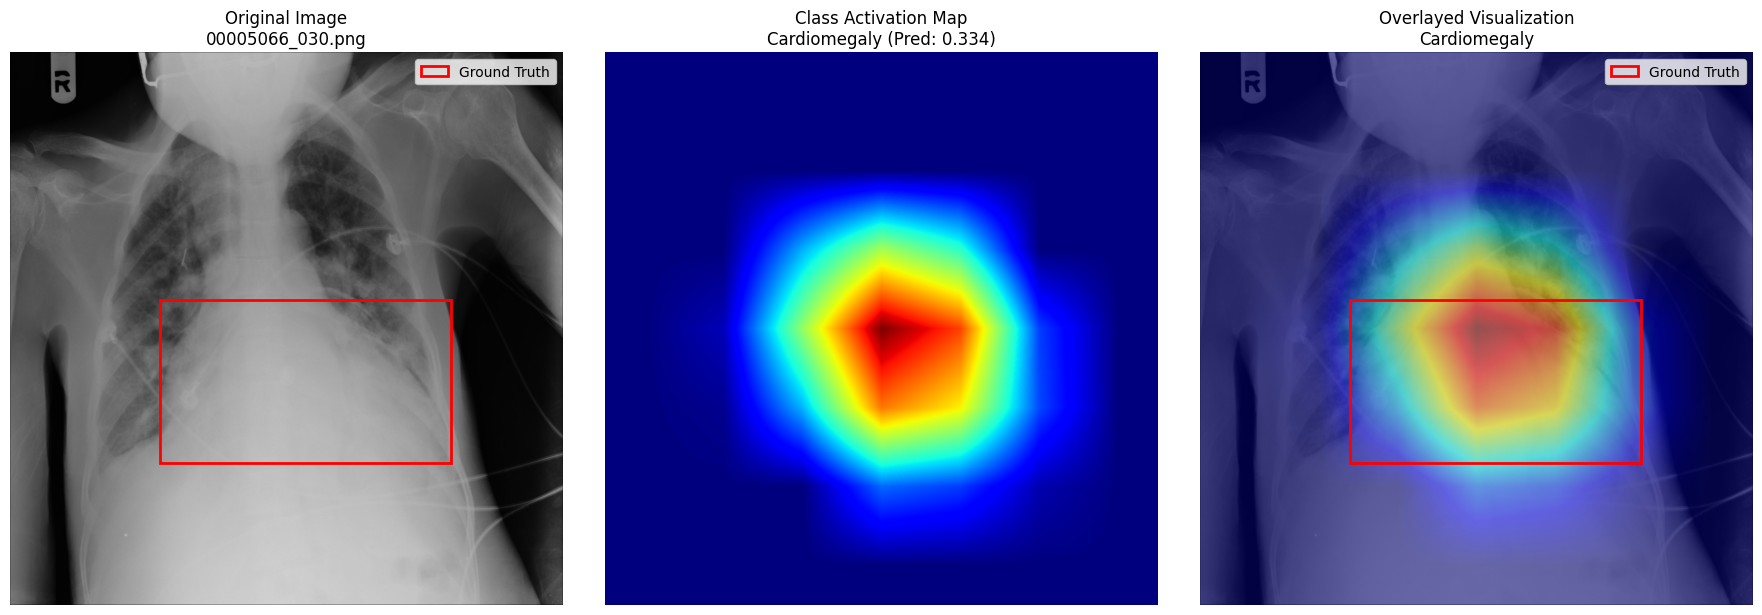


Visualizing: Effusion - 00010172_001.png
Saved to d:\ai_project\densenet_cam_results\cam_00010172_001_Effusion.png
Saved to d:\ai_project\densenet_cam_results\cam_00010172_001_Effusion.png


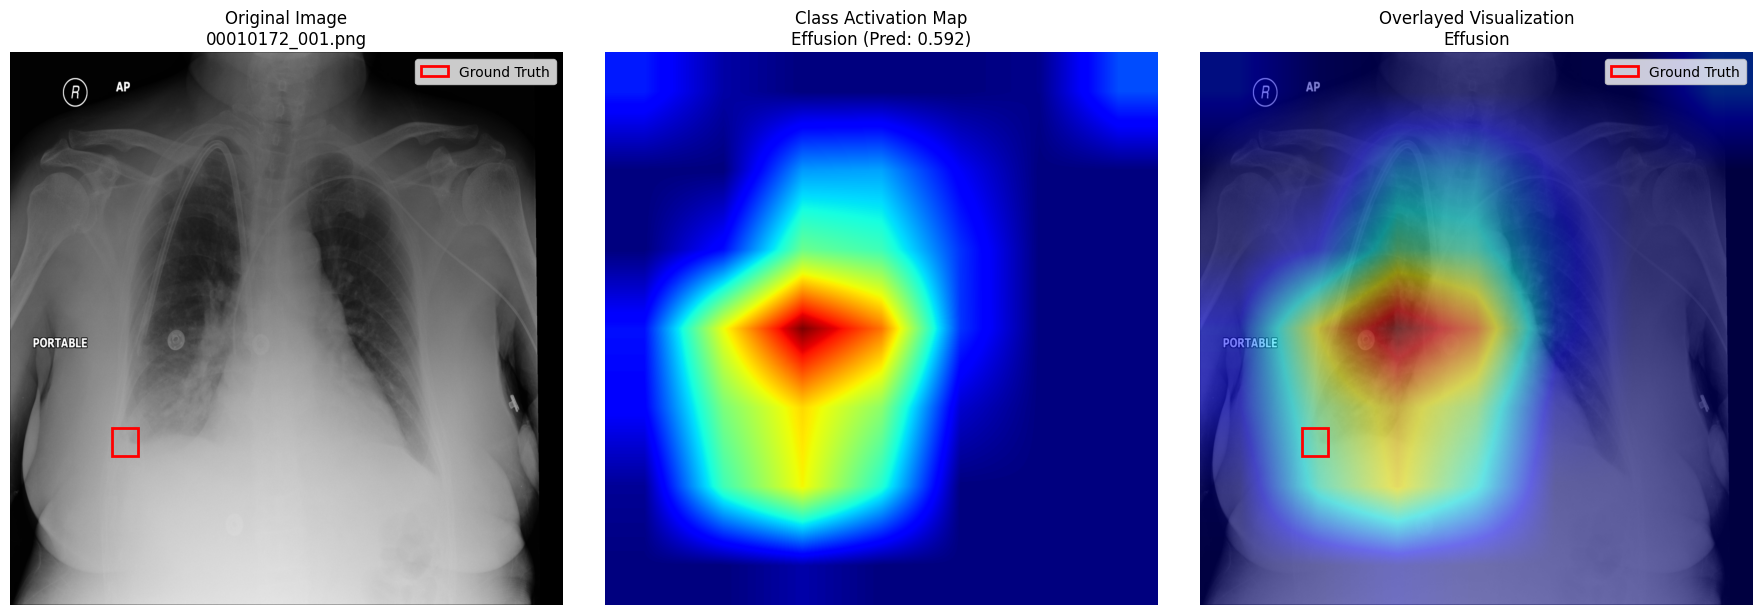

No test images with bbox for Infiltration

Visualizing: Mass - 00023075_033.png
Saved to d:\ai_project\densenet_cam_results\cam_00023075_033_Mass.png
Saved to d:\ai_project\densenet_cam_results\cam_00023075_033_Mass.png


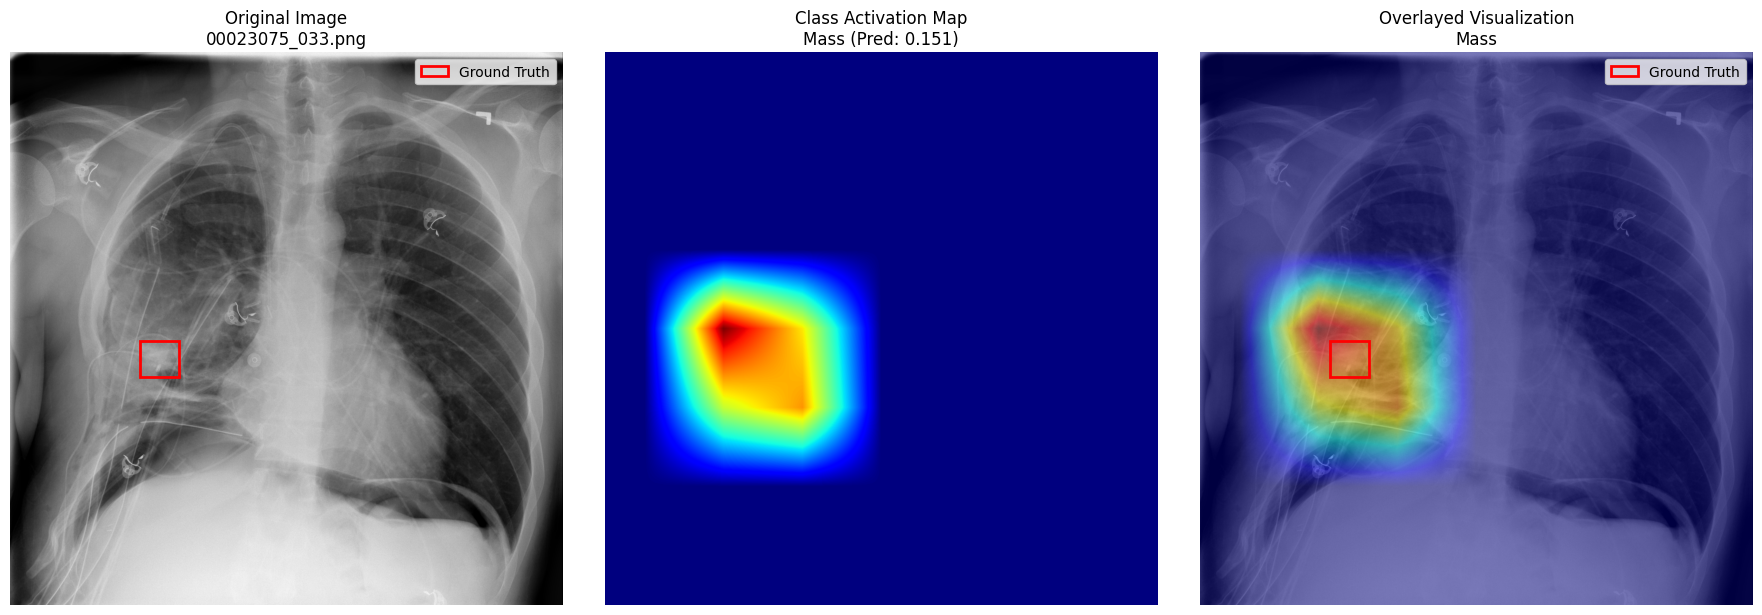


Visualizing: Nodule - 00001688_000.png
Saved to d:\ai_project\densenet_cam_results\cam_00001688_000_Nodule.png
Saved to d:\ai_project\densenet_cam_results\cam_00001688_000_Nodule.png


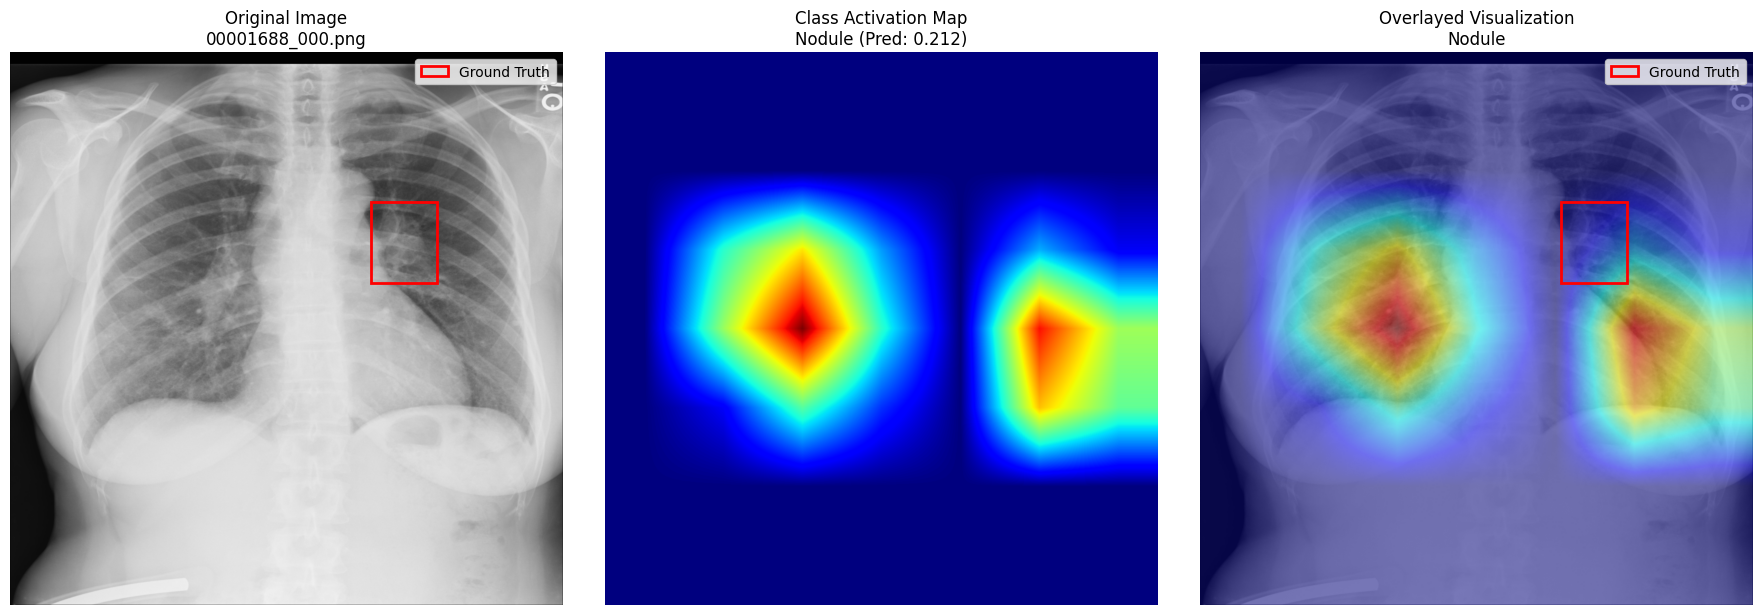


Visualizing: Pneumonia - 00011136_002.png
Saved to d:\ai_project\densenet_cam_results\cam_00011136_002_Pneumonia.png
Saved to d:\ai_project\densenet_cam_results\cam_00011136_002_Pneumonia.png


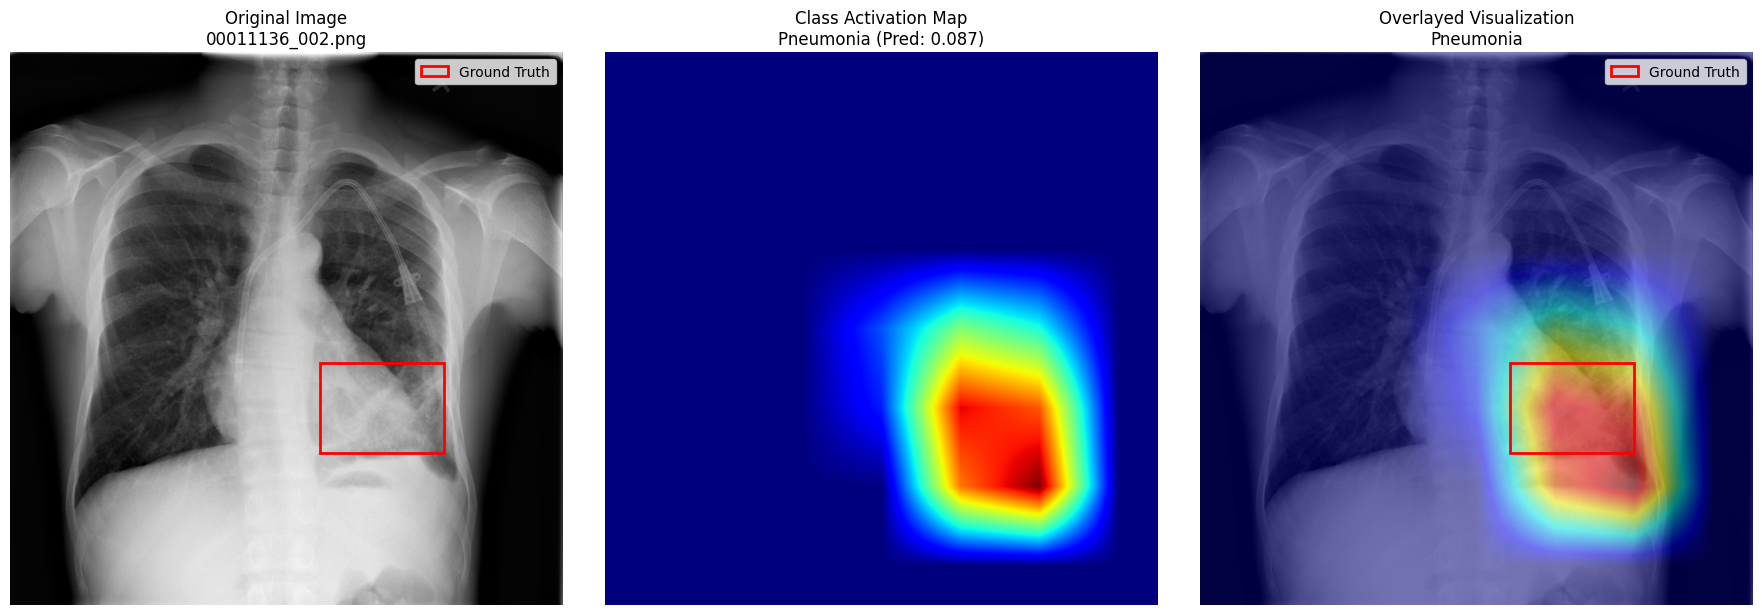


Visualizing: Pneumothorax - 00019892_003.png
Saved to d:\ai_project\densenet_cam_results\cam_00019892_003_Pneumothorax.png
Saved to d:\ai_project\densenet_cam_results\cam_00019892_003_Pneumothorax.png


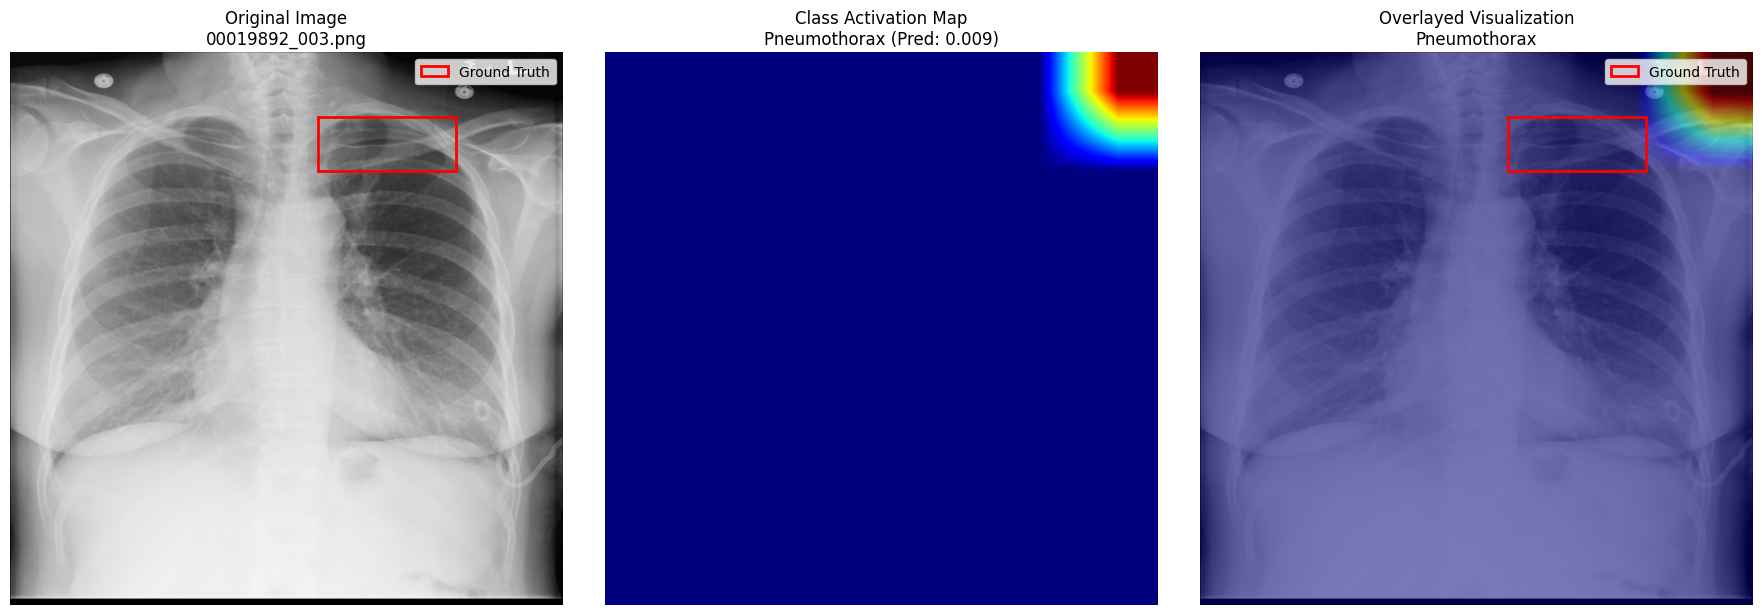

No test images with bbox for Consolidation
No test images with bbox for Edema
No test images with bbox for Emphysema
No test images with bbox for Fibrosis
No test images with bbox for Pleural_Thickening
No test images with bbox for Hernia


In [ ]:
sample_visualizations = []

for class_name in config.CLASS_NAMES:
    class_imgs = test_images_with_bbox[test_images_with_bbox['Finding Label'] == class_name]
    
    if len(class_imgs) > 0:
        # Pick first image
        sample_img = class_imgs.iloc[0]['Image Index']
        print(f"\n{'='*80}")
        print(f"Visualizing: {class_name} - {sample_img}")
        print(f"{'='*80}")
        
        try:
            overlayed, cam, pred = visualize_cam_with_bbox(sample_img, class_name, save=True)
            sample_visualizations.append({
                'image': sample_img,
                'class': class_name,
                'prediction': pred
            })
        except Exception as e:
            print(f"Error visualizing {sample_img} for {class_name}: {str(e)}")
    else:
        print(f"No test images with bbox for {class_name}")

## 10. Multi-Disease CAM Visualization

For images with multiple diseases, we can visualize CAMs for all detected pathologies.

In [ ]:
def visualize_multi_disease_cam(image_name, threshold=0.5):
    # Find image
    img_path = find_image_path(image_name)
    if img_path is None:
        print(f"Image {image_name} not found!")
        return
    
    # Load original image
    original_image = Image.open(img_path).convert('RGB')
    
    # Preprocess for model
    image_tensor = val_test_transform(original_image).unsqueeze(0).to(config.DEVICE)
    
    # Get predictions for all classes
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        predictions = torch.sigmoid(outputs)[0].cpu().numpy()
    
    # Find predicted classes above threshold
    predicted_classes = [(i, config.CLASS_NAMES[i], predictions[i]) 
                         for i in range(len(config.CLASS_NAMES)) 
                         if predictions[i] > threshold]
    
    # Sort by prediction score
    predicted_classes.sort(key=lambda x: x[2], reverse=True)
    
    if len(predicted_classes) == 0:
        print(f"No diseases predicted above threshold {threshold}")
        return
    
    print(f"Image: {image_name}")
    print(f"Predicted diseases (>{threshold}):")
    for idx, name, score in predicted_classes:
        print(f"  {name}: {score:.3f}")
    
    # Create subplot grid
    n_diseases = len(predicted_classes)
    n_cols = min(3, n_diseases)
    n_rows = (n_diseases + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
    if n_diseases == 1:
        axes = [axes]
    else:
        axes = axes.ravel()
    
    # Generate and plot CAM for each predicted disease
    for idx, (class_idx, class_name, pred_score) in enumerate(predicted_classes):
        overlayed, cam, _ = generate_cam_visualization(
            model, image_tensor, original_image, class_idx, class_name
        )
        
        axes[idx].imshow(overlayed)
        axes[idx].set_title(f'{class_name}\nPrediction: {pred_score:.3f}', fontsize=12, fontweight='bold')
        axes[idx].axis('off')
        
        # Add ground truth bbox if available
        bbox_rows = df_bbox[(df_bbox['Image Index'] == image_name) & 
                            (df_bbox['Finding Label'] == class_name)]
        if len(bbox_rows) > 0:
            for _, bbox_row in bbox_rows.iterrows():
                x, y, w, h = bbox_row['Bbox [x'], bbox_row['y'], bbox_row['w'], bbox_row['h]']
                rect = patches.Rectangle((x, y), w, h, linewidth=3, 
                                         edgecolor='lime', facecolor='none', label='Ground Truth')
                axes[idx].add_patch(rect)
            axes[idx].legend(loc='upper right')
    
    # Hide unused subplots
    for idx in range(n_diseases, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Multi-Disease CAM Visualization: {image_name}', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    save_path = config.OUTPUT_DIR / f'multi_cam_{image_name[:-4]}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved to {save_path}")
    plt.show()

print("Multi-disease CAM visualization function defined.")

Multi-disease CAM visualization function defined.


Test images with multiple diseases: 7743

Sample multi-disease images:
         Image Index                                     Finding Labels
7   00000003_003.png                                Hernia|Infiltration
39  00000013_001.png                             Emphysema|Pneumothorax
40  00000013_002.png                             Emphysema|Pneumothorax
42  00000013_004.png       Effusion|Emphysema|Infiltration|Pneumothorax
43  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...
44  00000013_006.png                              Effusion|Infiltration
48  00000013_010.png                    Effusion|Pneumonia|Pneumothorax
56  00000013_018.png                 Effusion|Infiltration|Pneumothorax
60  00000013_022.png                                  Infiltration|Mass
61  00000013_023.png                     Infiltration|Mass|Pneumothorax

Analyzing: 00019769_013.png
Ground truth: Consolidation|Infiltration|Mass
Image: 00019769_013.png
Predicted diseases (>0.5):
  Mass: 0.8

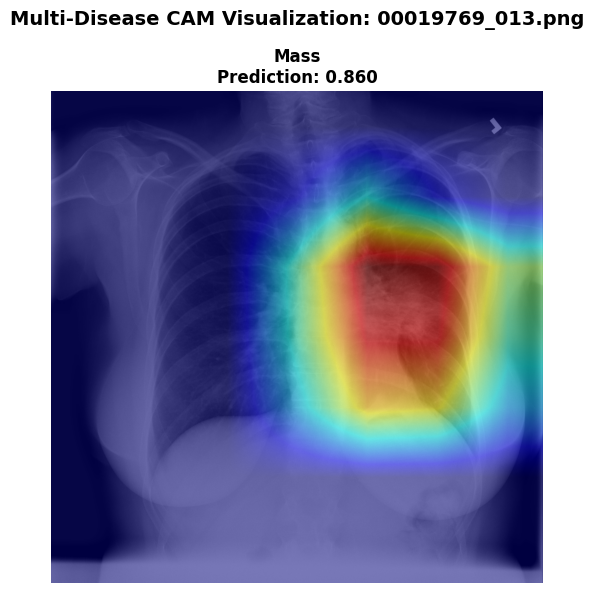


Analyzing: 00004381_048.png
Ground truth: Cardiomegaly|Effusion
Image: 00004381_048.png
Predicted diseases (>0.5):
  Cardiomegaly: 0.804
Image: 00004381_048.png
Predicted diseases (>0.5):
  Cardiomegaly: 0.804

Saved to d:\ai_project\densenet_cam_results\multi_cam_00004381_048.png

Saved to d:\ai_project\densenet_cam_results\multi_cam_00004381_048.png


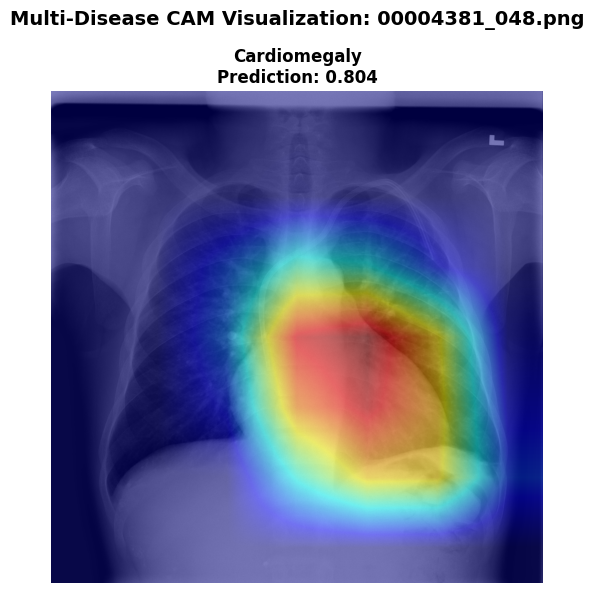


Analyzing: 00009608_004.png
Ground truth: Effusion|Infiltration
No diseases predicted above threshold 0.5
No diseases predicted above threshold 0.5


In [19]:
# Find test images with multiple diseases
test_metadata = df_metadata[df_metadata['Image Index'].isin(test_images)]
multi_disease = test_metadata[test_metadata['Finding Labels'].str.contains('\|', regex=True)]

print(f"Test images with multiple diseases: {len(multi_disease)}")
print("\nSample multi-disease images:")
print(multi_disease[['Image Index', 'Finding Labels']].head(10))

# Visualize a few multi-disease cases
sample_multi = multi_disease.sample(min(3, len(multi_disease)), random_state=42)

for _, row in sample_multi.iterrows():
    image_name = row['Image Index']
    print(f"\n{'='*80}")
    print(f"Analyzing: {image_name}")
    print(f"Ground truth: {row['Finding Labels']}")
    print(f"{'='*80}")
    
    try:
        visualize_multi_disease_cam(image_name, threshold=0.5)
    except Exception as e:
        print(f"Error: {str(e)}")

## 11. Quantitative Evaluation of Localization

For images with bounding boxes, we can compute IoU (Intersection over Union) between the CAM-based localization and ground truth boxes.

In [11]:
def cam_to_bbox(cam, threshold=0.5):
    """
    Convert CAM to bounding box by thresholding
    
    Args:
        cam: Class activation map (H x W)
        threshold: Threshold for binarization
        
    Returns:
        (x, y, w, h): Bounding box coordinates
    """
    # Threshold CAM
    binary_cam = (cam > threshold).astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(binary_cam, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    
    # Get largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get bounding box
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    return (x, y, w, h)

def compute_iou(box1, box2):
    """
    Compute IoU between two bounding boxes
    
    Args:
        box1: (x1, y1, w1, h1)
        box2: (x2, y2, w2, h2)
        
    Returns:
        IoU score
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Convert to (x1, y1, x2, y2) format
    box1_x2 = x1 + w1
    box1_y2 = y1 + h1
    box2_x2 = x2 + w2
    box2_y2 = y2 + h2
    
    # Compute intersection
    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(box1_x2, box2_x2)
    inter_y2 = min(box1_y2, box2_y2)
    
    if inter_x2 < inter_x1 or inter_y2 < inter_y1:
        return 0.0
    
    inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
    
    # Compute union
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    
    # Compute IoU
    iou = inter_area / union_area if union_area > 0 else 0.0
    
    return iou

def evaluate_localization(model, test_images_with_bbox_df, threshold=0.5):
    model.eval()
    
    iou_scores = []
    results = []
    
    unique_images = test_images_with_bbox_df['Image Index'].unique()
    
    print(f"Evaluating localization on {len(unique_images)} images with bounding boxes...")
    
    for image_name in tqdm(unique_images[:50]):  # Limit to 50 for speed
        # Get ground truth boxes for this image
        gt_boxes = test_images_with_bbox_df[test_images_with_bbox_df['Image Index'] == image_name]
        
        # Load image
        img_path = find_image_path(image_name)
        if img_path is None:
            continue
        
        original_image = Image.open(img_path).convert('RGB')
        image_tensor = val_test_transform(original_image).unsqueeze(0).to(config.DEVICE)
        
        # For each ground truth box
        for _, gt_row in gt_boxes.iterrows():
            class_name = gt_row['Finding Label']
            
            if class_name not in config.CLASS_NAMES:
                continue
            
            class_idx = config.CLASS_NAMES.index(class_name)
            
            # Generate CAM
            with torch.no_grad():
                output = model(image_tensor)
                prediction = torch.sigmoid(output)[0, class_idx].item()
            
            # Only evaluate if model predicts this class
            if prediction < 0.3:
                continue
            
            cam = model.get_cam(class_idx)
            
            # Resize CAM to original image size
            original_size = original_image.size
            cam_resized = cv2.resize(cam, original_size)
            
            # Convert CAM to bbox
            pred_bbox = cam_to_bbox(cam_resized, threshold=threshold)
            
            if pred_bbox is None:
                continue
            
            # Get ground truth bbox
            gt_bbox = (gt_row['Bbox [x'], gt_row['y'], gt_row['w'], gt_row['h]'])
            
            # Compute IoU
            iou = compute_iou(pred_bbox, gt_bbox)
            iou_scores.append(iou)
            
            results.append({
                'image': image_name,
                'class': class_name,
                'prediction': prediction,
                'iou': iou,
                'gt_bbox': gt_bbox,
                'pred_bbox': pred_bbox
            })
    
    # Compute statistics
    mean_iou = np.mean(iou_scores) if iou_scores else 0.0
    median_iou = np.median(iou_scores) if iou_scores else 0.0
    
    # Count how many have IoU > thresholds
    iou_05 = sum(1 for iou in iou_scores if iou > 0.5) / len(iou_scores) if iou_scores else 0.0
    iou_03 = sum(1 for iou in iou_scores if iou > 0.3) / len(iou_scores) if iou_scores else 0.0
    
    return {
        'mean_iou': mean_iou,
        'median_iou': median_iou,
        'iou_scores': iou_scores,
        'accuracy_iou_05': iou_05,
        'accuracy_iou_03': iou_03,
        'results': results
    }

print("Localization evaluation functions defined.")

Localization evaluation functions defined.


Evaluating localization on 880 images with bounding boxes...


  0%|          | 0/50 [00:00<?, ?it/s]


LOCALIZATION EVALUATION RESULTS
Number of evaluated boxes: 21
Mean IoU: 0.1535
Median IoU: 0.1556
Accuracy (IoU > 0.5): 0.00%
Accuracy (IoU > 0.3): 4.76%


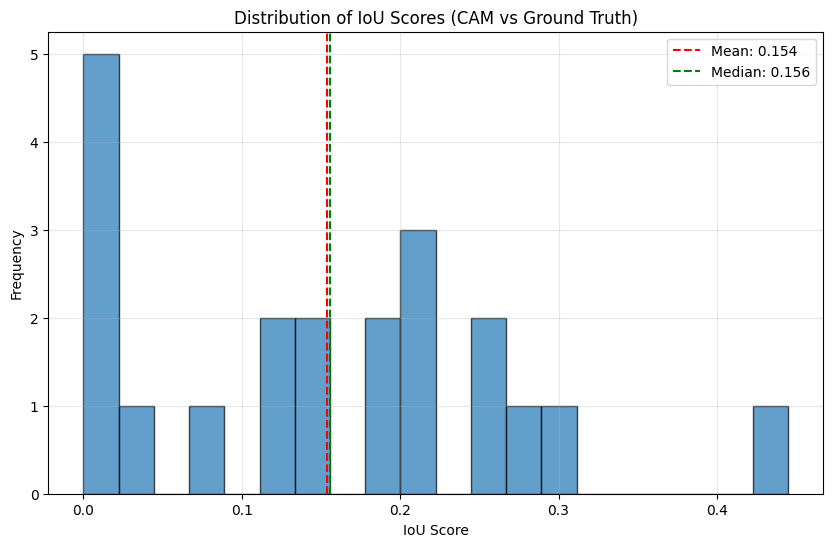


Detailed results saved to d:\ai_project\densenet_cam_results\localization_results.csv


In [35]:
# Run localization evaluation
loc_results = evaluate_localization(model, test_images_with_bbox, threshold=0.5)

print(f"\n{'='*80}")
print("LOCALIZATION EVALUATION RESULTS")
print(f"{'='*80}")
print(f"Number of evaluated boxes: {len(loc_results['iou_scores'])}")
print(f"Mean IoU: {loc_results['mean_iou']:.4f}")
print(f"Median IoU: {loc_results['median_iou']:.4f}")
print(f"Accuracy (IoU > 0.5): {loc_results['accuracy_iou_05']:.2%}")
print(f"Accuracy (IoU > 0.3): {loc_results['accuracy_iou_03']:.2%}")

# Plot IoU distribution
if loc_results['iou_scores']:
    plt.figure(figsize=(10, 6))
    plt.hist(loc_results['iou_scores'], bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(loc_results['mean_iou'], color='red', linestyle='--', label=f'Mean: {loc_results["mean_iou"]:.3f}')
    plt.axvline(loc_results['median_iou'], color='green', linestyle='--', label=f'Median: {loc_results["median_iou"]:.3f}')
    plt.xlabel('IoU Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of IoU Scores (CAM vs Ground Truth)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(config.OUTPUT_DIR / 'iou_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save detailed results
    loc_df = pd.DataFrame(loc_results['results'])
    loc_df.to_csv(config.OUTPUT_DIR / 'localization_results.csv', index=False)
    print(f"\nDetailed results saved to {config.OUTPUT_DIR / 'localization_results.csv'}")

## 12. Summary and Key Findings

In [36]:
print("="*80)
print("FINAL SUMMARY - NIH Chest X-ray Analysis")
print("="*80)

print("\n📊 DATASET STATISTICS:")
print(f"  • Total patients (train/val): {len(train_val_patients)}")
print(f"  • Train images: {len(train_images)}")
print(f"  • Validation images: {len(val_images)}")
print(f"  • Test images: {len(test_images)}")
print(f"  • No patient overlap between splits ✓")

print("\n🔬 MODEL ARCHITECTURE:")
print(f"  • Base model: DenseNet-121 (pretrained)")
print(f"  • Classes: {config.NUM_CLASSES} pathologies")
print(f"  • Task: Multi-label classification")
print(f"  • Localization: Class Activation Mapping (CAM)")

print("\n📈 CLASSIFICATION PERFORMANCE (Test Set):")
print(f"  • Mean AUC: {test_auc:.4f}")
print(f"  • Best classes:")
for class_name, auc in sorted(test_class_auc.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"    - {class_name}: {auc:.4f}")

print("\n🎯 LOCALIZATION PERFORMANCE (Test Set):")
if loc_results['iou_scores']:
    print(f"  • Mean IoU: {loc_results['mean_iou']:.4f}")
    print(f"  • Accuracy (IoU > 0.5): {loc_results['accuracy_iou_05']:.2%}")
    print(f"  • Accuracy (IoU > 0.3): {loc_results['accuracy_iou_03']:.2%}")

print("\n💾 SAVED OUTPUTS:")
print(f"  • Best model: {config.MODEL_SAVE_PATH}")
print(f"  • Test results: {config.OUTPUT_DIR / 'test_results.json'}")
print(f"  • Localization results: {config.OUTPUT_DIR / 'localization_results.csv'}")
print(f"  • CAM visualizations: {config.OUTPUT_DIR}")

print("\n✅ KEY ACHIEVEMENTS:")
print("  1. Proper patient-based train/test split (no data leakage)")
print("  2. Multi-label classification on 14 pathologies")
print("  3. Weakly supervised localization using CAM")
print("  4. Quantitative evaluation with IoU metrics")
print("  5. Visualization of disease-specific regions")

print("\n" + "="*80)

FINAL SUMMARY - NIH Chest X-ray Analysis

📊 DATASET STATISTICS:
  • Total patients (train/val): 28008
  • Train images: 77588
  • Validation images: 8936
  • Test images: 25596
  • No patient overlap between splits ✓

🔬 MODEL ARCHITECTURE:
  • Base model: DenseNet-121 (pretrained)
  • Classes: 14 pathologies
  • Task: Multi-label classification
  • Localization: Class Activation Mapping (CAM)

📈 CLASSIFICATION PERFORMANCE (Test Set):
  • Mean AUC: 0.8037
  • Best classes:
    - Emphysema: 0.8945
    - Hernia: 0.8865
    - Cardiomegaly: 0.8757
    - Pneumothorax: 0.8386
    - Edema: 0.8366

🎯 LOCALIZATION PERFORMANCE (Test Set):
  • Mean IoU: 0.1535
  • Accuracy (IoU > 0.5): 0.00%
  • Accuracy (IoU > 0.3): 4.76%

💾 SAVED OUTPUTS:
  • Best model: d:\ai_project\densenet_cam_results\best_densenet_model.pth
  • Test results: d:\ai_project\densenet_cam_results\test_results.json
  • Localization results: d:\ai_project\densenet_cam_results\localization_results.csv
  • CAM visualizations: d:\ai

## 13. Quick Test: Single Image Prediction

Test any image with any saved model checkpoint.

In [7]:
def test_single_image(image_path, model_checkpoint_path, threshold=0.5):
    """
    Test a single image with any model checkpoint
    
    Args:
        image_path: Path to the image file
        model_checkpoint_path: Path to the model checkpoint (.pth file)
        threshold: Threshold for disease detection (default 0.5)
    """
    # Load image
    img_name = Path(image_path).name
    original_image = Image.open(image_path).convert('RGB')
    
    # Preprocess
    image_tensor = val_test_transform(original_image).unsqueeze(0).to(config.DEVICE)
    
    # Load model checkpoint
    print(f"Loading model from: {model_checkpoint_path}")
    checkpoint = torch.load(model_checkpoint_path, map_location=config.DEVICE)
    
    # Create fresh model and load weights
    test_model = DenseNetCAM(num_classes=config.NUM_CLASSES, pretrained=False)
    test_model.load_state_dict(checkpoint['model_state_dict'])
    test_model = test_model.to(config.DEVICE)
    test_model.eval()
    
    print(f"✓ Model loaded (Epoch {checkpoint['epoch']+1}, Val AUC: {checkpoint.get('val_auc', 'N/A')})")
    print(f"\nTesting image: {img_name}")
    print(f"Original size: {original_image.size}")
    
    # Get predictions
    with torch.no_grad():
        outputs = test_model(image_tensor)
        probabilities = torch.sigmoid(outputs).squeeze().cpu().numpy()
    
    # Create predictions dict
    predictions = {
        name: float(prob) 
        for name, prob in zip(config.CLASS_NAMES, probabilities)
    }
    
    # Print all predictions sorted by confidence
    print(f"\n{'='*80}")
    print("ALL DISEASE PROBABILITIES (sorted by confidence):")
    print(f"{'='*80}")
    sorted_preds = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
    for disease, prob in sorted_preds:
        marker = "✓" if prob >= threshold else " "
        print(f"  {marker} {disease:20s}: {prob:.2%}")
    
    # Filter detected diseases
    detected_diseases = [
        (name, prob) 
        for name, prob in predictions.items() 
        if prob >= threshold
    ]
    detected_diseases.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n{'='*80}")
    print(f"DETECTED DISEASES (above {threshold} threshold): {len(detected_diseases)}")
    print(f"{'='*80}")
    if detected_diseases:
        for disease, prob in detected_diseases:
            print(f"  • {disease}: {prob:.2%}")
    else:
        print("  • No significant findings")
    
    # Visualize with CAM for detected diseases
    if detected_diseases:
        print(f"\nGenerating CAM visualizations...")
        n_diseases = len(detected_diseases)
        n_cols = min(3, n_diseases)
        n_rows = (n_diseases + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
        if n_diseases == 1:
            axes = [axes]
        else:
            axes = axes.ravel() if n_diseases > 1 else [axes]
        
        for idx, (disease_name, prob) in enumerate(detected_diseases):
            class_idx = config.CLASS_NAMES.index(disease_name)
            
            # Generate CAM
            with torch.no_grad():
                _ = test_model(image_tensor)  # Forward pass to get feature maps
            
            overlayed, cam, prediction = generate_cam_visualization(
                test_model, image_tensor, original_image, class_idx, disease_name
            )
            
            axes[idx].imshow(overlayed)
            axes[idx].set_title(f'{disease_name}\nConfidence: {prob:.1%}', 
                               fontsize=12, fontweight='bold')
            axes[idx].axis('off')
        
        # Hide unused subplots
        for idx in range(n_diseases, len(axes)):
            axes[idx].axis('off')
        
        plt.suptitle(f'Disease Detection Results: {img_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        # Show original image
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.imshow(original_image, cmap='gray')
        ax.set_title(f'No Significant Findings\n{img_name}', fontsize=14, fontweight='bold')
        ax.axis('off')
        plt.show()
    
    return predictions, detected_diseases

print("Single image test function defined.")
print("\nUsage:")
print("  predictions, detected = test_single_image(")
print("      image_path='path/to/your/image.png',")
print("      model_checkpoint_path=config.CHECKPOINTS_DIR / 'densenet_epoch_08.pth',")
print("      threshold=0.5")
print("  )")

Single image test function defined.

Usage:
  predictions, detected = test_single_image(
      image_path='path/to/your/image.png',
      model_checkpoint_path=config.CHECKPOINTS_DIR / 'densenet_epoch_08.pth',
      threshold=0.5
  )


### Example: Test Your Own Image

Loading model from: d:\ai_project\densenet_cam_results\checkpoints\densenet_epoch_06.pth
✓ Model loaded (Epoch 6, Val AUC: 0.8238102566415781)

Testing image: images (1).jpeg
Original size: (245, 206)

ALL DISEASE PROBABILITIES (sorted by confidence):
    Mass                : 59.13%
    Effusion            : 11.37%
    Pleural_Thickening  : 9.37%
    Infiltration        : 6.56%
    Atelectasis         : 5.59%
    Nodule              : 3.99%
    Consolidation       : 3.65%
    Emphysema           : 3.28%
    Pneumothorax        : 1.17%
    Fibrosis            : 0.82%
    Pneumonia           : 0.63%
    Cardiomegaly        : 0.57%
    Edema               : 0.29%
    Hernia              : 0.14%

DETECTED DISEASES (above 0.6 threshold): 0
  • No significant findings


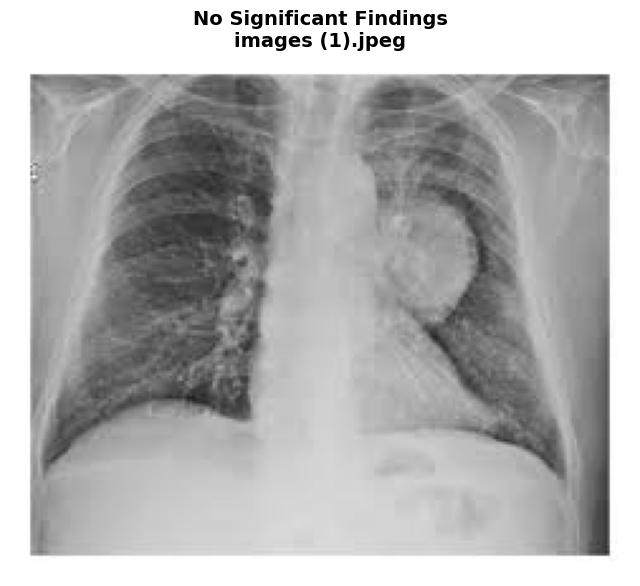

: 

In [ ]:
# Example 1: Test with epoch 8 model
test_image_path = r'D:/ai_project/heart_dataset/images_009/images/00019769_013.png'
checkpoint_path = config.CHECKPOINTS_DIR / 'densenet_epoch_08.pth'

predictions, detected = test_single_image(
    image_path=test_image_path,
    model_checkpoint_path=checkpoint_path,
    threshold=0.6
)

Loading model from: d:\ai_project\densenet_cam_results\best_densenet_model.pth
✓ Model loaded (Epoch 8, Val AUC: 0.8298923582641381)

Testing image: 00000013_035.png
Original size: (1024, 1024)

ALL DISEASE PROBABILITIES (sorted by confidence):
  ✓ Emphysema           : 95.21%
  ✓ Pneumothorax        : 71.43%
    Infiltration        : 7.37%
    Atelectasis         : 7.26%
    Cardiomegaly        : 4.45%
    Nodule              : 2.36%
    Mass                : 2.36%
    Effusion            : 2.32%
    Consolidation       : 2.00%
    Pleural_Thickening  : 1.24%
    Fibrosis            : 0.50%
    Edema               : 0.25%
    Pneumonia           : 0.15%
    Hernia              : 0.07%

DETECTED DISEASES (above 0.3 threshold): 2
  • Emphysema: 95.21%
  • Pneumothorax: 71.43%

Generating CAM visualizations...


NameError: name 'generate_cam_visualization' is not defined

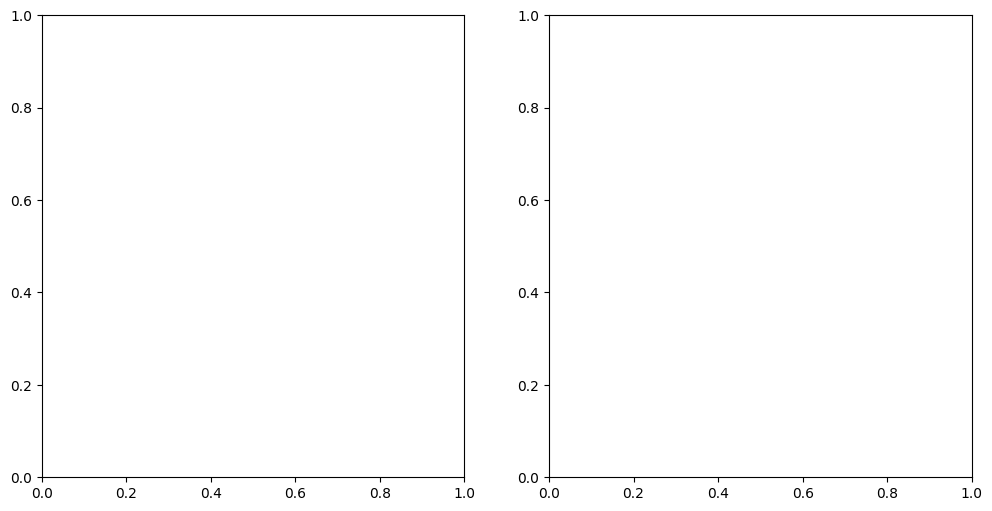

In [9]:
# Example 2: Test with best model and lower threshold
predictions2, detected2 = test_single_image(
    image_path=test_image_path,
    model_checkpoint_path=config.MODEL_SAVE_PATH,  # Best model
    threshold=0.3  # Lower threshold to catch weaker predictions
)

In [ ]:
# Example 3: Compare multiple epochs on the same image
print("\n" + "="*80)
print("COMPARING DIFFERENT EPOCHS ON SAME IMAGE")
print("="*80)

epochs_to_compare = [5, 8, 10]  # Change these to any epochs you want to compare

for epoch_num in epochs_to_compare:
    checkpoint_path = config.CHECKPOINTS_DIR / f'densenet_epoch_{epoch_num:02d}.pth'
    
    if checkpoint_path.exists():
        print(f"\n{'─'*80}")
        print(f"EPOCH {epoch_num}:")
        print(f"{'─'*80}")
        
        # Quick test without visualization
        checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
        test_model = DenseNetCAM(num_classes=config.NUM_CLASSES, pretrained=False)
        test_model.load_state_dict(checkpoint['model_state_dict'])
        test_model = test_model.to(config.DEVICE)
        test_model.eval()
        
        original_image = Image.open(test_image_path).convert('RGB')
        image_tensor = val_test_transform(original_image).unsqueeze(0).to(config.DEVICE)
        
        with torch.no_grad():
            outputs = test_model(image_tensor)
            probabilities = torch.sigmoid(outputs).squeeze().cpu().numpy()
        
        # Show top 3 predictions
        predictions_dict = {name: float(prob) for name, prob in zip(config.CLASS_NAMES, probabilities)}
        top_3 = sorted(predictions_dict.items(), key=lambda x: x[1], reverse=True)[:3]
        
        for disease, prob in top_3:
            print(f"  {disease:20s}: {prob:.2%}")
    else:
        print(f"\nEpoch {epoch_num}: Checkpoint not found")

## Comprehensive Model Evaluation - Choose Any Checkpoint

In [12]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_comprehensive(model, test_loader, device, class_names, threshold=0.5):
    """
    Comprehensive evaluation of a model on test set
    
    Returns:
    - Accuracy (per-class and overall)
    - F1 Score (per-class and macro/micro)
    - Sensitivity (Recall)
    - Specificity
    - AUC-ROC (per-class and macro/micro)
    - AUPRC (Average Precision)
    - ROC curves for all classes
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []
    
    print("Evaluating model on test set...")
    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['image'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_predictions.append((probs > threshold).cpu().numpy())
    
    # Concatenate all batches
    all_probs = np.vstack(all_probs)
    all_labels = np.vstack(all_labels)
    all_predictions = np.vstack(all_predictions)
    
    num_classes = len(class_names)
    
    # Initialize metric storage
    results = {
        'class_names': class_names,
        'per_class': {},
        'overall': {}
    }
    
    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL EVALUATION RESULTS")
    print("="*80)
    
    # Per-class metrics
    print("\nPER-CLASS METRICS:")
    print("-"*80)
    print(f"{'Class':<25} {'Acc':>8} {'F1':>8} {'Sens':>8} {'Spec':>8} {'AUC':>8} {'AUPRC':>8}")
    print("-"*80)
    
    for i, class_name in enumerate(class_names):
        y_true = all_labels[:, i]
        y_pred = all_predictions[:, i]
        y_prob = all_probs[:, i]
        
        # Calculate metrics
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        # Sensitivity (Recall/TPR) and Specificity (TNR)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        # AUC-ROC and AUPRC
        try:
            auc_roc = roc_auc_score(y_true, y_prob)
            auprc = average_precision_score(y_true, y_prob)
        except:
            auc_roc = 0.0
            auprc = 0.0
        
        results['per_class'][class_name] = {
            'accuracy': acc,
            'f1': f1,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'auc_roc': auc_roc,
            'auprc': auprc
        }
        
        print(f"{class_name:<25} {acc:>8.4f} {f1:>8.4f} {sensitivity:>8.4f} {specificity:>8.4f} {auc_roc:>8.4f} {auprc:>8.4f}")
    
    print("-"*80)
    
    # Overall metrics
    print("\nOVERALL METRICS:")
    print("-"*80)
    
    # Macro and Micro averages
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    micro_f1 = f1_score(all_labels, all_predictions, average='micro', zero_division=0)
    
    macro_auc = roc_auc_score(all_labels, all_probs, average='macro')
    micro_auc = roc_auc_score(all_labels, all_probs, average='micro')
    
    macro_auprc = average_precision_score(all_labels, all_probs, average='macro')
    micro_auprc = average_precision_score(all_labels, all_probs, average='micro')
    
    # Sample-based accuracy
    sample_accuracy = np.mean(all_predictions == all_labels)
    
    results['overall'] = {
        'sample_accuracy': sample_accuracy,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1,
        'macro_auc': macro_auc,
        'micro_auc': micro_auc,
        'macro_auprc': macro_auprc,
        'micro_auprc': micro_auprc
    }
    
    print(f"Sample-based Accuracy: {sample_accuracy:.4f}")
    print(f"Macro F1 Score:        {macro_f1:.4f}")
    print(f"Micro F1 Score:        {micro_f1:.4f}")
    print(f"Macro AUC-ROC:         {macro_auc:.4f}")
    print(f"Micro AUC-ROC:         {micro_auc:.4f}")
    print(f"Macro AUPRC:           {macro_auprc:.4f}")
    print(f"Micro AUPRC:           {micro_auprc:.4f}")
    print("="*80)
    
    # Plot ROC curves for all classes
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    axes = axes.ravel()
    
    for i, class_name in enumerate(class_names):
        y_true = all_labels[:, i]
        y_prob = all_probs[:, i]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot
        axes[i].plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC curve (AUC = {roc_auc:.3f})')
        axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('False Positive Rate', fontsize=10)
        axes[i].set_ylabel('True Positive Rate', fontsize=10)
        axes[i].set_title(f'{class_name}', fontsize=12, fontweight='bold')
        axes[i].legend(loc="lower right", fontsize=8)
        axes[i].grid(alpha=0.3)
    
    # Hide any unused subplots
    for i in range(len(class_names), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('ROC Curves for All Disease Classes', fontsize=16, fontweight='bold', y=1.001)
    plt.show()
    
    return results

print("Comprehensive evaluation function loaded!")

Comprehensive evaluation function loaded!


In [23]:
# Choose which checkpoint to evaluate
EVAL_CHECKPOINT_PATH = config.CHECKPOINTS_DIR / 'densenet_epoch_06.pth'  # Change to any epoch or best_model.pth
EVAL_THRESHOLD = 0.2  # Adjust threshold for predictions

# Load the checkpoint
print(f"Loading checkpoint: {EVAL_CHECKPOINT_PATH}")
checkpoint = torch.load(EVAL_CHECKPOINT_PATH, map_location=config.DEVICE)

# Load model
eval_model = DenseNetCAM(num_classes=len(config.CLASS_NAMES)).to(config.DEVICE)
eval_model.load_state_dict(checkpoint['model_state_dict'])

# Print checkpoint info
print(f"\nCheckpoint Information:")
print(f"Epoch: {checkpoint['epoch']+1}")
print(f"Validation AUC: {checkpoint.get('val_auc', 'N/A')}")
print(f"Threshold: {EVAL_THRESHOLD}")

# Run comprehensive evaluation
results = evaluate_model_comprehensive(
    model=eval_model,
    test_loader=test_loader,
    device=config.DEVICE,
    class_names=config.CLASS_NAMES,
    threshold=EVAL_THRESHOLD
)

Loading checkpoint: d:\ai_project\densenet_cam_results\checkpoints\densenet_epoch_06.pth

Checkpoint Information:
Epoch: 6
Validation AUC: 0.8238102566415781
Threshold: 0.2
Evaluating model on test set...

Checkpoint Information:
Epoch: 6
Validation AUC: 0.8238102566415781
Threshold: 0.2
Evaluating model on test set...


  0%|          | 0/1600 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Overall Model Performance (Image-Level Metrics)

Evaluate overall model performance considering that each image can have multiple diseases or no diseases.

In [19]:
def evaluate_overall_model_performance(model, test_loader, device, threshold=0.2):
    """
    Evaluate overall model performance at the image level.
    For each image, considers if ANY disease is correctly predicted.
    
    Metrics:
    - Image-level accuracy: Did we get the image classification right?
    - Exact match: All diseases predicted correctly (strict)
    - Hamming accuracy: Proportion of correct labels per image
    - Any disease detected: If image has disease, did we catch ANY of them?
    - No disease accuracy: For healthy images, did we correctly predict no disease?
    - Overall metrics: Accuracy, F1, Sensitivity, Specificity, AUC-ROC, AUPRC
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []
    
    print("Evaluating overall model performance...")
    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['image'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_predictions.append((probs > threshold).cpu().numpy())
    
    # Concatenate all batches
    all_probs = np.vstack(all_probs)
    all_labels = np.vstack(all_labels)
    all_predictions = np.vstack(all_predictions)
    
    num_images = all_labels.shape[0]
    num_classes = all_labels.shape[1]
    
    print("\n" + "="*80)
    print("OVERALL MODEL PERFORMANCE (IMAGE-LEVEL)")
    print("="*80)
    
    # 1. Exact Match Accuracy (all diseases must be correct)
    exact_matches = np.all(all_predictions == all_labels, axis=1)
    exact_match_acc = np.mean(exact_matches)
    
    # 2. Hamming Accuracy (average per-label accuracy across all images)
    hamming_acc = np.mean(all_predictions == all_labels)
    
    # 3. OVERALL CLASSIFICATION METRICS (treating as micro-averaged across all labels)
    # Flatten all predictions and labels for overall metrics
    y_true_flat = all_labels.flatten()
    y_pred_flat = all_predictions.flatten()
    y_prob_flat = all_probs.flatten()
    
    # Calculate confusion matrix components
    tp = np.sum((y_true_flat == 1) & (y_pred_flat == 1))
    tn = np.sum((y_true_flat == 0) & (y_pred_flat == 0))
    fp = np.sum((y_true_flat == 0) & (y_pred_flat == 1))
    fn = np.sum((y_true_flat == 1) & (y_pred_flat == 0))
    
    # Overall metrics
    overall_accuracy = accuracy_score(y_true_flat, y_pred_flat)
    overall_f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
    overall_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
    overall_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # AUC-ROC and AUPRC (micro-averaged)
    try:
        overall_auc = roc_auc_score(y_true_flat, y_prob_flat)
        overall_auprc = average_precision_score(y_true_flat, y_prob_flat)
        
        # Calculate ROC curve for plotting
        fpr, tpr, thresholds = roc_curve(y_true_flat, y_prob_flat)
    except:
        overall_auc = 0.0
        overall_auprc = 0.0
        fpr, tpr, thresholds = [0, 1], [0, 1], [0, 1]
    
    # 3. Images with at least one disease
    images_with_disease = np.any(all_labels == 1, axis=1)
    num_diseased_images = np.sum(images_with_disease)
    
    # 4. For diseased images: Did we detect ANY disease?
    if num_diseased_images > 0:
        predicted_any_disease = np.any(all_predictions == 1, axis=1)
        detected_any_disease = predicted_any_disease[images_with_disease]
        any_disease_detection_rate = np.mean(detected_any_disease)
    else:
        any_disease_detection_rate = 0.0
    
    # 5. Images with no disease (healthy)
    healthy_images = ~images_with_disease
    num_healthy_images = np.sum(healthy_images)
    
    # 6. For healthy images: Did we correctly predict no disease?
    if num_healthy_images > 0:
        predicted_healthy = np.all(all_predictions == 0, axis=1)
        correct_healthy = predicted_healthy[healthy_images]
        healthy_accuracy = np.mean(correct_healthy)
    else:
        healthy_accuracy = 0.0
    
    # 7. At least one correct prediction per diseased image
    if num_diseased_images > 0:
        # For each diseased image, check if at least one true positive
        at_least_one_correct = []
        for i in range(num_images):
            if images_with_disease[i]:
                # Get indices where ground truth is 1
                true_disease_indices = np.where(all_labels[i] == 1)[0]
                # Check if we predicted at least one of them correctly
                any_correct = np.any(all_predictions[i, true_disease_indices] == 1)
                at_least_one_correct.append(any_correct)
        
        at_least_one_correct_rate = np.mean(at_least_one_correct)
    else:
        at_least_one_correct_rate = 0.0
    
    # 8. Average number of diseases per image
    avg_diseases_per_image_true = np.mean(np.sum(all_labels, axis=1))
    avg_diseases_per_image_pred = np.mean(np.sum(all_predictions, axis=1))
    
    # 9. Over/Under prediction analysis
    over_predictions = np.sum(all_predictions) - np.sum(all_labels)
    
    print(f"\n📊 DATASET COMPOSITION:")
    print(f"  Total images:                {num_images:,}")
    print(f"  Images with disease:         {num_diseased_images:,} ({num_diseased_images/num_images*100:.1f}%)")
    print(f"  Healthy images (no disease): {num_healthy_images:,} ({num_healthy_images/num_images*100:.1f}%)")
    print(f"  Avg diseases per image:      {avg_diseases_per_image_true:.2f}")
    
    print(f"\n🎯 OVERALL CLASSIFICATION METRICS (Micro-averaged):")
    print(f"  Accuracy:                    {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    print(f"  F1 Score:                    {overall_f1:.4f}")
    print(f"  Sensitivity (Recall):        {overall_sensitivity:.4f} ({overall_sensitivity*100:.2f}%)")
    print(f"  Specificity:                 {overall_specificity:.4f} ({overall_specificity*100:.2f}%)")
    print(f"  AUC-ROC:                     {overall_auc:.4f}")
    print(f"  AUPRC (Avg Precision):       {overall_auprc:.4f}")
    
    print(f"\n📋 CONFUSION MATRIX (All Labels):")
    print(f"  True Positives (TP):         {tp:,}")
    print(f"  True Negatives (TN):         {tn:,}")
    print(f"  False Positives (FP):        {fp:,}")
    print(f"  False Negatives (FN):        {fn:,}")
    
    print(f"\n🎯 IMAGE-LEVEL METRICS:")
    print(f"  Exact Match Accuracy:        {exact_match_acc:.4f} ({exact_match_acc*100:.2f}%)")
    print(f"  Hamming Accuracy:            {hamming_acc:.4f} ({hamming_acc*100:.2f}%)")
    print(f"    (Average per-label correctness across all images)")
    
    print(f"\n🔍 DISEASE DETECTION PERFORMANCE:")
    print(f"  Any Disease Detection Rate:  {any_disease_detection_rate:.4f} ({any_disease_detection_rate*100:.2f}%)")
    print(f"    (For diseased images: Did we detect ANY disease?)")
    print(f"  At Least One Correct:        {at_least_one_correct_rate:.4f} ({at_least_one_correct_rate*100:.2f}%)")
    print(f"    (For diseased images: Did we get at least ONE disease right?)")
    
    print(f"\n✅ HEALTHY IMAGE PERFORMANCE:")
    print(f"  Healthy Image Accuracy:      {healthy_accuracy:.4f} ({healthy_accuracy*100:.2f}%)")
    print(f"    (For healthy images: Did we correctly predict no disease?)")
    
    print(f"\n📈 PREDICTION STATISTICS:")
    print(f"  Avg predicted diseases/image: {avg_diseases_per_image_pred:.2f}")
    print(f"  Total predictions:            {np.sum(all_predictions):,}")
    print(f"  Total ground truth:           {np.sum(all_labels):,}")
    print(f"  Prediction bias:              {over_predictions:+,}")
    if over_predictions > 0:
        print(f"    → Model is OVER-predicting (predicting more diseases than actual)")
    elif over_predictions < 0:
        print(f"    → Model is UNDER-predicting (missing diseases)")
    else:
        print(f"    → Model predictions are balanced")
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {overall_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    plt.title('Overall ROC Curve (Micro-averaged across all diseases)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n💡 INTERPRETATION:")
    if exact_match_acc < 0.5:
        print(f"  ⚠️ Low exact match accuracy ({exact_match_acc*100:.1f}%) is normal for multi-label problems")
        print(f"     with many classes. Focus on Hamming accuracy and disease detection rate.")
    
    if any_disease_detection_rate > 0.9:
        print(f"  ✓ Excellent: Detecting diseases in {any_disease_detection_rate*100:.1f}% of diseased images")
    elif any_disease_detection_rate > 0.7:
        print(f"  ⚠️ Moderate: Missing diseases in {(1-any_disease_detection_rate)*100:.1f}% of diseased images")
    else:
        print(f"  ❌ Poor: Missing diseases in {(1-any_disease_detection_rate)*100:.1f}% of diseased images")
    
    if healthy_accuracy < 0.8 and num_healthy_images > 0:
        print(f"  ⚠️ Too many false positives on healthy images")
        print(f"     Consider raising threshold or addressing specificity")
    
    print("="*80)
    
    return {
        'exact_match_accuracy': exact_match_acc,
        'hamming_accuracy': hamming_acc,
        'overall_accuracy': overall_accuracy,
        'overall_f1': overall_f1,
        'overall_sensitivity': overall_sensitivity,
        'overall_specificity': overall_specificity,
        'overall_auc': overall_auc,
        'overall_auprc': overall_auprc,
        'any_disease_detection_rate': any_disease_detection_rate,
        'at_least_one_correct_rate': at_least_one_correct_rate,
        'healthy_accuracy': healthy_accuracy,
        'num_diseased_images': num_diseased_images,
        'num_healthy_images': num_healthy_images,
        'avg_diseases_per_image_true': avg_diseases_per_image_true,
        'avg_diseases_per_image_pred': avg_diseases_per_image_pred,
        'prediction_bias': over_predictions,
        'confusion_matrix': {'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn)}
    }

print("Overall model evaluation function loaded!")

Overall model evaluation function loaded!


Running overall image-level evaluation...

Evaluating overall model performance...


  0%|          | 0/1600 [00:00<?, ?it/s]


OVERALL MODEL PERFORMANCE (IMAGE-LEVEL)

📊 DATASET COMPOSITION:
  Total images:                25,596
  Images with disease:         15,735 (61.5%)
  Healthy images (no disease): 9,861 (38.5%)
  Avg diseases per image:      1.06

🎯 OVERALL CLASSIFICATION METRICS (Micro-averaged):
  Accuracy:                    0.8895 (88.95%)
  F1 Score:                    0.4044
  Sensitivity (Recall):        0.4941 (49.41%)
  Specificity:                 0.9220 (92.20%)
  AUC-ROC:                     0.8516
  AUPRC (Avg Precision):       0.3472

📋 CONFUSION MATRIX (All Labels):
  True Positives (TP):         13,442
  True Negatives (TN):         305,307
  False Positives (FP):        25,831
  False Negatives (FN):        13,764

🎯 IMAGE-LEVEL METRICS:
  Exact Match Accuracy:        0.2099 (20.99%)
  Hamming Accuracy:            0.8895 (88.95%)
    (Average per-label correctness across all images)

🔍 DISEASE DETECTION PERFORMANCE:
  Any Disease Detection Rate:  0.8836 (88.36%)
    (For diseased image

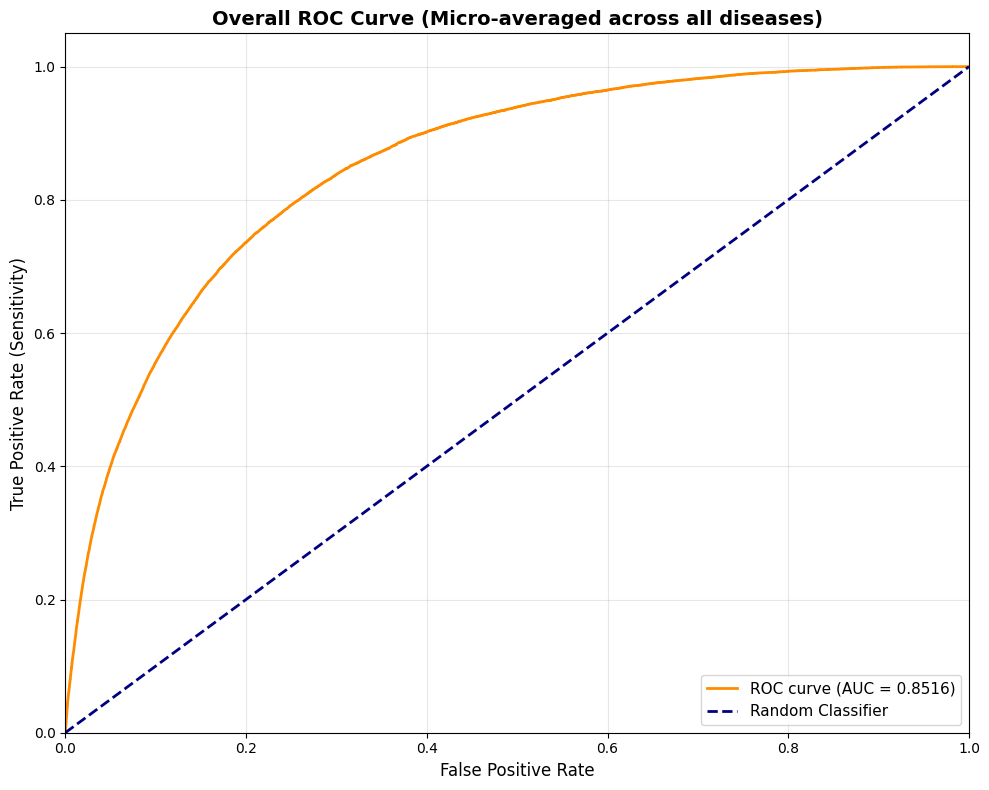


💡 INTERPRETATION:
  ⚠️ Low exact match accuracy (21.0%) is normal for multi-label problems
     with many classes. Focus on Hamming accuracy and disease detection rate.
  ⚠️ Moderate: Missing diseases in 11.6% of diseased images
  ⚠️ Too many false positives on healthy images
     Consider raising threshold or addressing specificity


In [24]:
# Run overall evaluation on the same model
print("Running overall image-level evaluation...\n")

overall_results = evaluate_overall_model_performance(
    model=eval_model,
    test_loader=test_loader,
    device=config.DEVICE,
    threshold=0.2
)

## Confusion Matrix Visualization

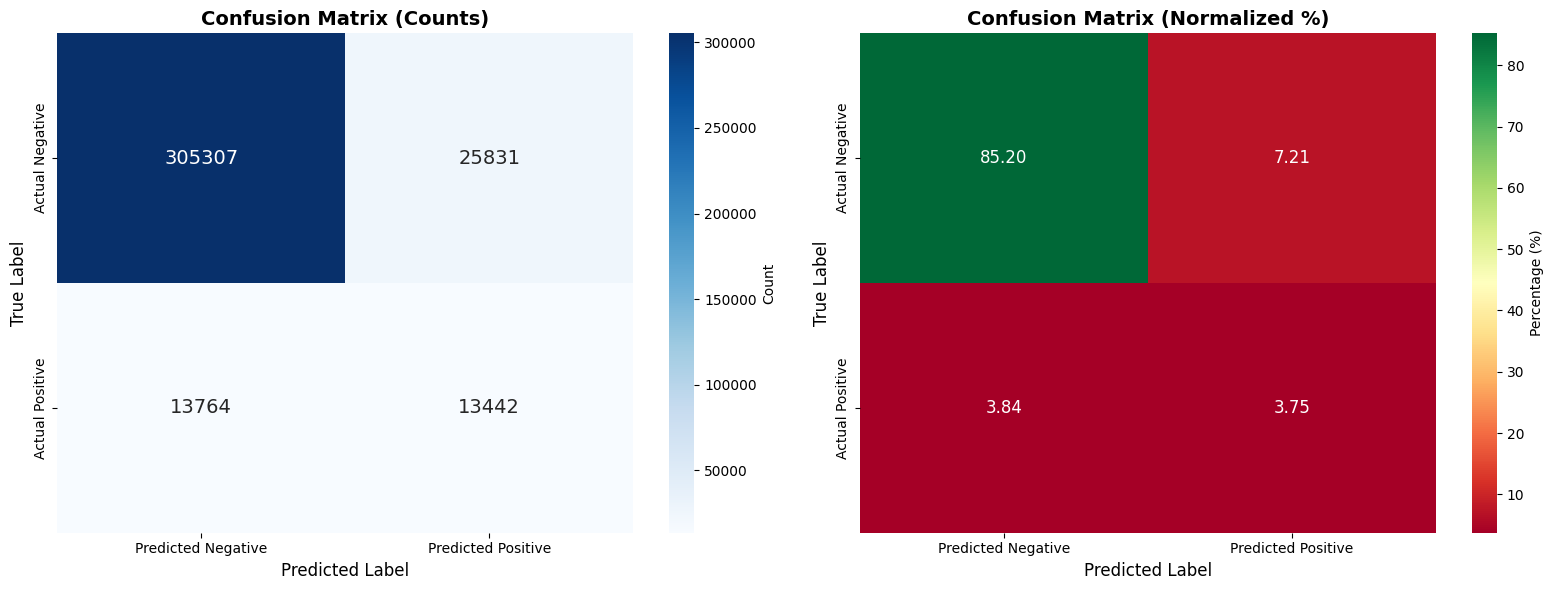


DETAILED CONFUSION MATRIX ANALYSIS

📊 COUNTS:
  True Positives (TP):     13,442  (Correctly predicted positive)
  True Negatives (TN):    305,307  (Correctly predicted negative)
  False Positives (FP):    25,831  (Incorrectly predicted positive)
  False Negatives (FN):    13,764  (Incorrectly predicted negative)
  Total:                  358,344

📈 PERCENTAGES:
  TP:   3.75%
  TN:  85.20%
  FP:   7.21%
  FN:   3.84%

🎯 DERIVED METRICS:
  Sensitivity (Recall):      0.4941 (49.41%)
    = TP / (TP + FN) = 13442 / 27206
  Specificity:               0.9220 (92.20%)
    = TN / (TN + FP) = 305307 / 331138
  Precision:                 0.3423
    = TP / (TP + FP) = 13442 / 39273
  Negative Predictive Value: 0.9569
    = TN / (TN + FN) = 305307 / 319071

💡 INTERPRETATION:
  ✓ Good specificity: Model avoids false positives
  ⚠️ Low sensitivity: Missing many positive cases


In [25]:
# Extract confusion matrix from results
import seaborn as sns

cm = overall_results['confusion_matrix']
tp = cm['TP']
tn = cm['TN']
fp = cm['FP']
fn = cm['FN']

# Create confusion matrix visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Standard Confusion Matrix Heatmap
confusion_matrix_array = np.array([[tn, fp], 
                                   [fn, tp]])

sns.heatmap(confusion_matrix_array, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            cbar_kws={'label': 'Count'}, ax=axes[0], annot_kws={'size': 14})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# 2. Normalized Confusion Matrix (percentages)
total = tp + tn + fp + fn
confusion_matrix_normalized = np.array([[tn/total*100, fp/total*100], 
                                        [fn/total*100, tp/total*100]])

sns.heatmap(confusion_matrix_normalized, annot=True, fmt='.2f', cmap='RdYlGn', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            cbar_kws={'label': 'Percentage (%)'}, ax=axes[1], annot_kws={'size': 12})
axes[1].set_title('Confusion Matrix (Normalized %)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

# Print detailed confusion matrix analysis
print("\n" + "="*80)
print("DETAILED CONFUSION MATRIX ANALYSIS")
print("="*80)

print(f"\n📊 COUNTS:")
print(f"  True Positives (TP):   {tp:>8,}  (Correctly predicted positive)")
print(f"  True Negatives (TN):   {tn:>8,}  (Correctly predicted negative)")
print(f"  False Positives (FP):  {fp:>8,}  (Incorrectly predicted positive)")
print(f"  False Negatives (FN):  {fn:>8,}  (Incorrectly predicted negative)")
print(f"  Total:                 {total:>8,}")

print(f"\n📈 PERCENTAGES:")
print(f"  TP: {tp/total*100:>6.2f}%")
print(f"  TN: {tn/total*100:>6.2f}%")
print(f"  FP: {fp/total*100:>6.2f}%")
print(f"  FN: {fn/total*100:>6.2f}%")

print(f"\n🎯 DERIVED METRICS:")
print(f"  Sensitivity (Recall):      {overall_results['overall_sensitivity']:.4f} ({overall_results['overall_sensitivity']*100:.2f}%)")
print(f"    = TP / (TP + FN) = {tp} / {tp+fn}")
print(f"  Specificity:               {overall_results['overall_specificity']:.4f} ({overall_results['overall_specificity']*100:.2f}%)")
print(f"    = TN / (TN + FP) = {tn} / {tn+fp}")
print(f"  Precision:                 {tp/(tp+fp) if (tp+fp) > 0 else 0:.4f}")
print(f"    = TP / (TP + FP) = {tp} / {tp+fp}")
print(f"  Negative Predictive Value: {tn/(tn+fn) if (tn+fn) > 0 else 0:.4f}")
print(f"    = TN / (TN + FN) = {tn} / {tn+fn}")

print(f"\n💡 INTERPRETATION:")
sensitivity = overall_results['overall_sensitivity']
specificity = overall_results['overall_specificity']

if sensitivity > 0.85 and specificity > 0.85:
    print(f"  ✓ Excellent balance: Both sensitivity and specificity are high")
elif sensitivity > 0.8:
    print(f"  ✓ Good sensitivity: Model catches most positive cases")
    if specificity < 0.8:
        print(f"  ⚠️ Low specificity: Many false positives - model is too aggressive")
elif specificity > 0.85:
    print(f"  ✓ Good specificity: Model avoids false positives")
    print(f"  ⚠️ Low sensitivity: Missing many positive cases")
else:
    print(f"  ⚠️ Poor balance: Both metrics could be improved")

print("="*80)